# <font size="6"><b>Study Abstract</b></font> 

<font size='4'> Low-frequency blood-oxygenated-level-dependent (BOLD) signals are known to exhibit a global spatiotemporal pattern of activity at rest, labeled the quasiperiodic pattern (QPP). This spatiotemporal pattern can be described as a recurring global propagation of BOLD activity from task-positive network regions towards default mode network regions. Alongside the QPP, a wide variety of functional connectivity topographies contrasting task-positive and default mode network regions have been reported in the literature. In this study, we demonstrate that most widely-studied functional connectivity topographies arise from the same spatiotemporal dynamics - the QPP. In other words, much of the resting-state fMRI literature has been describing the same thing with different methods. Using resting-state functional magnetic resonance imaging scans from the Human Connectome Project (n=50), we examined the relationship between previously observed functional connectivity topographies and the time-lagged dynamics of the QPP. We find that the time-lagged dynamics of the QPP are distributed across multiple axes in low-dimensional functional connectivity space(s). Popular functional connectivity topographies generally correspond to one or more of these axes. Thus, functional connectivity topographies represent low-dimensional descriptions of the synchronous dynamics within the larger time-lagged QPP pattern. We further demonstrate that ‘global signal’ and ‘task-positive/task-negative’ functional connectivity topographies arise from the same dynamics of the QPP: a time-lag in BOLD signals between task-positive and task-negative network regions. Overall, we find that the QPP underlies a striking variety of previously observed phenomena in low-frequency resting-state BOLD signals.</font>

## Module Imports

In [360]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nibabel as nb
import numpy as np
import pandas as pd
import pickle

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from matplotlib import cm, colors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch, BoxStyle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import random as rand
from run_main_pca import pca as cpca
from scipy import linalg
from scipy.signal import resample, welch, hilbert
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats import zscore
from sklearn.decomposition import KernelPCA, PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import MDS, Isomap
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import minmax_scale
from sknetwork.clustering import Louvain, modularity
from utils.utils import load_data_and_stack, load_gifti, pull_gifti_data, load_cifti, pull_cifti_data, \
write_to_gifti, double_gamma_hrf, convolve_hrf_events


## Helper Functions

In [2]:
# Global variables
tr = 0.72
n_vertices = 4801
n_vert_L=2562
n_ts=60000


# Helper Functions
def axis3d_scaler(x, y, z):
    # https://stackoverflow.com/questions/30223161/matplotlib-mplot3d-how-to-increase-the-size-of-an-axis-stretch-in-a-3d-plot
    scale=np.diag([x, y, z, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=1.0
    return scale  


def circular_corr(alpha1, alpha2, nanrobust, axis=None):
#     Take from:
#     https://github.com/jhamrick/python-snippets/blob/master/snippets/circstats.py
    if axis is not None and alpha1.shape[axis] != alpha2.shape[axis]:
        raise(ValueError, "shape mismatch")

    # compute mean directions
    if axis is None:
        n = alpha1.size
    else:
        n = alpha1.shape[axis]

    #################################################################
    c1 = np.cos(alpha1)
    c1_2 = np.cos(2*alpha1)
    c2 = np.cos(alpha2)
    c2_2 = np.cos(2*alpha2)
    s1 = np.sin(alpha1)
    s1_2 = np.sin(2*alpha1)
    s2 = np.sin(alpha2)
    s2_2 = np.sin(2*alpha2)

    if nanrobust:
        sumfunc = lambda x: np.nansum(x, axis=axis)
    else:
        sumfunc = lambda x: np.sum(x, axis=axis)

    num = 4 * (sumfunc(c1*c2) * sumfunc(s1*s2) -
               sumfunc(c1*s2) * sumfunc(s1*c2))
    den = np.sqrt((n**2 - sumfunc(c1_2)**2 - sumfunc(s1_2)**2) *
                  (n**2 - sumfunc(c2_2)**2 - sumfunc(s2_2)**2))

    rho = num / den

    return rho

def convert_polar_xticks_to_radians(ax):
    # https://stackoverflow.com/questions/21172228/python-matplotlib-polar-plots-with-angular-labels-in-radians
    # Converts x-tick labels from degrees to radians
    # Get the x-tick positions (returns in radians)
    label_positions = ax.get_xticks()
    # Convert to a list since we want to change the type of the elements
    labels = list(label_positions)
    # Format each label (edit this function however you'd like)
    labels = [format_radians_label(label) for label in labels]
    ax.set_xticklabels(labels)
    

def create_hrf_group(n_ts, activation_indx, ts_len, tr, amplitude, phase_jitter, 
                     amplitude_jitter, ts_sampling=0.01, repeat_n=1):
    """
    n_ts: number of timeseries
    activation_indx = index of activation time point
    ts_len: length of time series
    tr: the sampling rate of the original time series
    amplitude: amplitude of double gamma function 
    phase_offset_window: allowable phase offsets between time series - 
        set as a symmetric window length - sampled from uniform distribution
    ts_sampling: resolution of original time series - default=0.01 Hz
    std_noise: amount of gaussian noise to add to time series - scaling parameter between 0 and 1
    """
    hrf=double_gamma_hrf(60, ts_sampling)
    ts_all = np.zeros((n_ts, ts_len))
    for n in range(n_ts):
        ts = ts_all[n,:]
        indx = rand.randint(activation_indx - phase_jitter, 
                          activation_indx + phase_jitter)
        amp = rand.randint(amplitude - amplitude_jitter, 
                           amplitude + amplitude_jitter)
        ts[indx] = 1
        ts_all[n,:] = (convolve_hrf_events(hrf, ts) * amplitude)
    n_resample=np.int(ts_sampling*ts_len/tr)
    hrf_ts_resample = resample(ts_all, n_resample, axis=1)
    return np.tile(hrf_ts_resample, repeat_n)

def cropImage(img, width, height):
    return img[height[0]:-height[1]:,width[0]:-width[1],:]


def format_radians_label(float_in):
    # https://stackoverflow.com/questions/21172228/python-matplotlib-polar-plots-with-angular-labels-in-radians
    # Converts a float value in radians into a
    # string representation of that float
    string_out = str(float_in / (np.pi))+"π"
    
    return string_out


def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.1)


def image_3d(ax, arr, label, xy, offset_x, offset_y, label_offset_y=0, zoom=0.05, pad=0):
    """ Place an image (arr) as annotation at position xy 
        https://stackoverflow.com/questions/48180327/matplotlib-3d-scatter-plot-with-images-as-annotations
    """
    im = OffsetImage(arr, zoom=zoom)
    im.image.axes = ax
    ab = AnnotationBbox(im, xy, xybox=(offset_x, offset_y),
                        xycoords='data', boxcoords="offset points",
                        pad=pad, arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
    offsetbox = TextArea(label, minimumdescent=False)
    ab = AnnotationBbox(offsetbox, xy,
                    xybox=(offset_x, offset_y+label_offset_y),
                    xycoords='data',
                    boxcoords=("offset points"))
    
    ax.add_artist(ab)

    
def plot_error_line(line_list):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(bootstrap_df.index, bootstrap_df.mean(axis=1), alpha=0.5, color='blue', label='train', linewidth = 2.0)
    ax.fill_between(bootstrap_df.index, bootstrap_df.mean(axis=1) - bootstrap_df.std(axis=1), 
                    bootstrap_df.mean(axis=1) + bootstrap_df.std(axis=1), color='#888888', alpha=0.4)
    ax.fill_between(bootstrap_df.index, bootstrap_df.mean(axis=1) - 2*bootstrap_df.std(axis=1), 
                    bootstrap_df.mean(axis=1) + 2*bootstrap_df.std(axis=1), color='#888888', alpha=0.2)
    plt.yticks(fontweight='bold', fontsize=15)
    plt.xticks([2009, 2011, 2013, 2015, 2017, 2019], 
               [2009, 2011, 2013, 2015, 2017, 2019], 
               fontweight='bold', fontsize=15)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    plt.grid(True)

    
def plot_sorted_corr_mat(corr_mat, cluster_assignments, ax):
    # Create sorting index from factor assignments
    sort_indx = np.argsort(cluster_assignments)
    sorted_vals = np.sort(cluster_assignments)
    # Sort Distance Matrix
    sortedmat = [[corr_mat[i][j] for j in sort_indx] for i in sort_indx]
    # Plot Distance Matrix
    c = ax.pcolormesh(sortedmat, cmap='coolwarm')
    plt.colorbar(c, ax=ax)
    # Plot rectangular patches along diagnol to indicate factor assignments
    for i in np.unique(sorted_vals):
        ind = np.where(sorted_vals == i)
        mn = np.min(ind)
        mx = np.max(ind)
        sz=(mx-mn)+1
        rect = Rectangle((mn,mn), sz, sz , linewidth=1, 
                         edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    
    
def proj_3d(X, ax1, ax2):
    """ From a 3D point in axes ax1, 
        calculate position in 2D in ax2 
        https://stackoverflow.com/questions/48180327/matplotlib-3d-scatter-plot-with-images-as-annotations
    """
    x,y,z = X
    x2, y2, _ = proj3d.proj_transform(x,y,z, ax1.get_proj())
    return ax2.transData.inverted().transform(ax1.transData.transform((x2, y2)))


def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
        0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


def transition_matrix(transitions):
    #https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
    n = 1 + np.int(np.nanmax(transitions)) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        if ~np.isnan(i) and ~np.isnan(j):
            M[np.int(i)][np.int(j)] += 1
    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)


def xcorr(x, y, maxlags=30):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')
    c = np.correlate(x, y, mode=2)
    c /= np.sqrt(np.dot(x, x) * np.dot(y, y))
    if maxlags is None:
        maxlags = Nx - 1
    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maglags must be None or strictly '
                         'positive < %d' % Nx)
    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    max_r = c[np.argsort(np.abs(c))[-1]]
    max_lag = lags[np.argsort(np.abs(c))[-1]]
    return max_r, max_lag


/Users/taylorbolt/opt/miniconda3/envs/bold_waves/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create ROY-BIG-BL brain colormap that matches HCP Workbench

In [3]:
colors_roy = ["cyan", "lime", "blueviolet",  "mediumblue", "black", "red", "orange", "yellow"]
roy_big_bl = LinearSegmentedColormap.from_list("roy_big_bl", colors_roy)

# <b>Figure 1 - Survey of Zero-lag FC Topographies.</b>

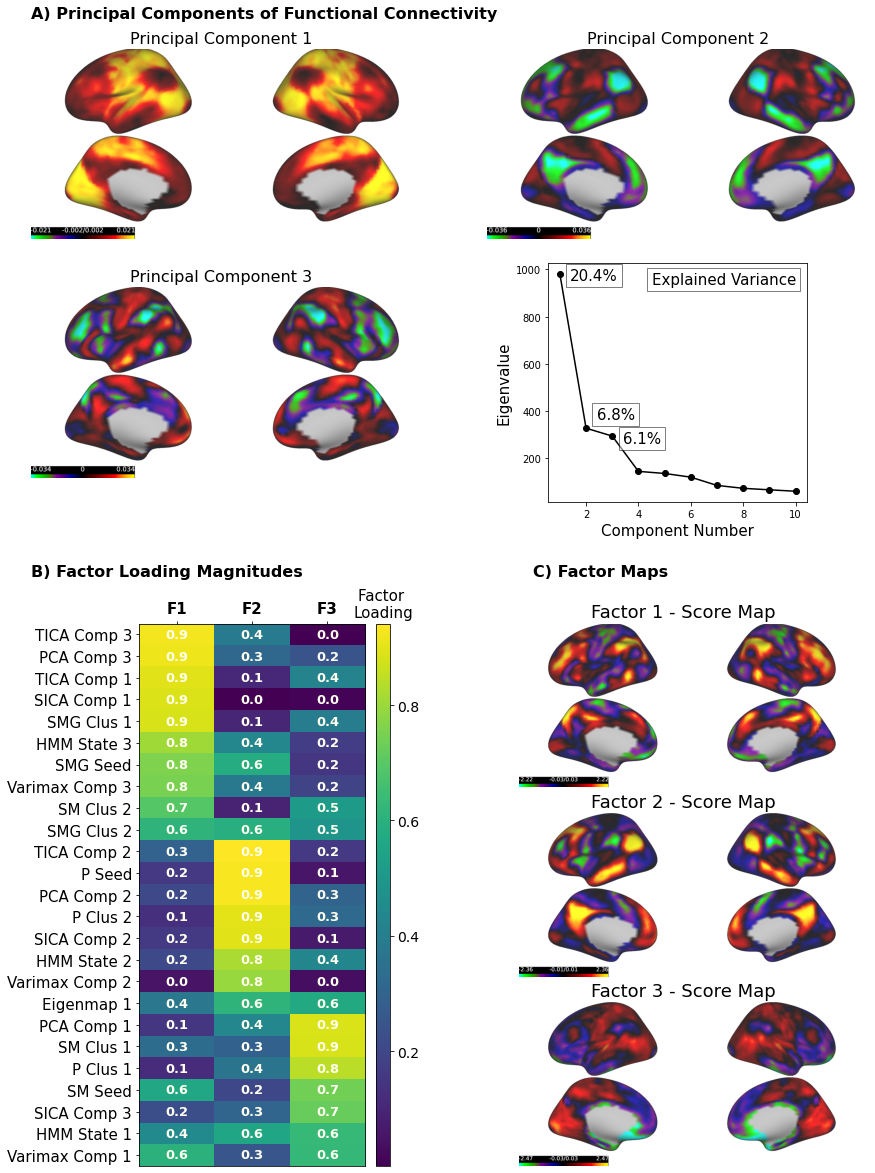

In [265]:
cifti_fps = (
    'demo_files/pca_rest.dtseries.nii',  
    'demo_files/eigenmap_p90.dtseries.nii',
    'demo_files/fc_map_precuneus.dtseries.nii',
    'demo_files/fc_map_sm.dtseries.nii',  
    'demo_files/fc_map_supramarginal.dtseries.nii', 
    'demo_files/pca_rest_varimax.dtseries.nii',
    'demo_files/s_ica.dtseries.nii', 'demo_files/t_ica.dtseries.nii', 
    'demo_files/caps_precuneus_c2.dtseries.nii',
    'demo_files/caps_sm_c2.dtseries.nii',
    'demo_files/caps_supramarginal_c2.dtseries.nii',
    'demo_files/hmm_mean_map.dtseries.nii'
)
labels_short = (
    'PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3',
    'Eigenmap 1', 'P Seed', 'SM Seed', 'SMG Seed',
    'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 'SICA Comp 1', 'SICA Comp 2', 
    'SICA Comp 3', 'TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3', 'P Clus 1', 'P Clus 2', 
    'SM Clus 1', 'SM Clus 2', 'SMG Clus 1', 'SMG Clus 2', 'HMM State 1', 'HMM State 2',
    'HMM State 3'
)
section_labels = (
    'Principal Component Analysis', 
    'Laplacian Eigenmaps',
    'Precuneus Seed Regression', 
    'Somatosensory Seed Regression', 
    'Supramarginal Seed Regression',
    'Principal Component Analysis - Varimax Rotated', 
    'Spatial Independent Component Analysis', 
    'Temporal Independent Component Analysis', 
    'Precuneus Seed CAPS', 
    'SM Seed CAPs',
    'Supramarginal Seed CAPS',
    'GMM Hidden Markov Model'
)

## 1. Load All Maps
cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    if any([label in fp for label in ['pca_rest', 'ica', 'hmm']]):
        cifti_maps_all.append(cifti_maps[:3, :])
    elif 'eigenmap' in fp:
        cifti_maps_all.append(cifti_maps[0, :])
    else:
        cifti_maps_all.append(cifti_maps[:2, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()
# Normalize
cifti_maps_all = zscore(cifti_maps_all.T)

## 2. Run PCA to estimate Number of Factors
pca = PCA(n_components=10)
pca.fit(cifti_maps_all)
exp_var = pca.explained_variance_
# Scree plot indicates a 3-factor solution

## 3. Run Factor Analysis w/ varimax rotation (3 components)
fa = FactorAnalysis(n_components=3, rotation='varimax', random_state=0)
fa.fit(cifti_maps_all)
rotated_scores = fa.transform(cifti_maps_all)
factor_corrs = np.corrcoef(rotated_scores.T)

## 4. Write factor score maps to cifti files
# This cannot be done without access to data, so it is commented out
# ex_subj_file = ['data/rest/proc_3_surf_resamp/200513_LR1_rest_smooth_filt_smooth_filt_resamp.R.func.gii', 
#                 'data/rest/proc_3_surf_resamp/200513_LR1_rest_smooth_filt_smooth_filt_resamp.L.func.gii']
# hdr = load_gifti(ex_subj_file)
# # flip sign of first and third component for consistency
# rotated_scores[:,2]*=-1
# write_to_gifti(rotated_scores.T, hdr, 'factor_analysis_allmaps', zero_mask)

## 5. Calculate PCA explained variance
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
eigs = [np.var(pca_ts[:,i]) for i in range(pca_ts.shape[1])]
exp_var = [eig/n_vertices for eig in eigs]

## 6. Create Figure
crop_width = (35, 150)
crop_height = (5,15)
fig = plt.figure(figsize=(15,21), constrained_layout=False)
gspec = fig.add_gridspec(2,1, hspace=0.15, wspace=0, height_ratios=[0.45,0.55])

title_ax = fig.add_subplot(gspec[0])
title_ax.set_title('A) Principal Components of Functional Connectivity', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')

g_sub_title = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[1], wspace=0.5)
title_ax = fig.add_subplot(g_sub_title[0])
title_ax.set_title('B) Factor Loading Magnitudes', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')

title_ax = fig.add_subplot(g_sub_title[1])
title_ax.set_title('C) Factor Maps', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')

g_sub0 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gspec[0], wspace=0.2, hspace=0)
ax = fig.add_subplot(g_sub0[0,0])
img = mpimg.imread('demo_files/pca_rest_comp0.png')
ax.set_title('Principal Component 1', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

ax = fig.add_subplot(g_sub0[0,1])
img = mpimg.imread('demo_files/pca_rest_comp1.png')
ax.set_title('Principal Component 2', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

ax = fig.add_subplot(g_sub0[1,0])
img = mpimg.imread('demo_files/pca_rest_comp2.png')
ax.set_title('Principal Component 3', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

ax = fig.add_subplot(g_sub0[1,1])
ax.set_aspect(0.009)
ax.plot(list(range(1,11)), eigs, '-o', color='black')
ax.set_xlabel('Component Number', fontsize=15)
ax.set_ylabel('Eigenvalue', fontsize=15)
x_adj = 0.4
y_adj = [-25,40,-30]
for i in range(3):
    ax.text((i+1)+x_adj,eigs[i]+y_adj[i], 
            r'{}%'.format(np.round(exp_var[i]*100,1)), 
            fontsize=15, bbox=dict(facecolor='white', alpha=0.5))
ax.text(4.5, 940, 'Explained Variance', fontsize=15, bbox=dict(facecolor='white', alpha=0.5))

g_sub1 = gridspec.GridSpecFromSubplotSpec(4,2, subplot_spec=gspec[1], hspace=0.2, wspace=0, 
                                         width_ratios=[0.3, 0.7], height_ratios=[0.03,0.3,0.3,0.3])

factor_maps = ['demo_files/factor_analysis_allmaps_f0.png', 
               'demo_files/factor_analysis_allmaps_f1.png', 
               'demo_files/factor_analysis_allmaps_f2.png']

weights_df = pd.DataFrame(fa.components_.T, columns=[f'Comp{i}' for i in range(3)], index=labels_short)
weights_df_abs = weights_df.abs()
df_list = []
indx_max = weights_df_abs.idxmax(axis=1)
for col in weights_df_abs.columns:
    comp_weights = weights_df_abs.loc[indx_max==col]
    comp_weights_sorted = comp_weights.sort_values(by=col, ascending=False)
    df_list.append(comp_weights_sorted)
weights_df_abs_sorted = pd.concat(df_list)

ax = fig.add_subplot(g_sub1[1:,0])
im = ax.imshow(weights_df_abs_sorted.values, aspect='auto')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(len(labels_short)))
ax.set_yticklabels(weights_df_abs_sorted.index, fontsize=15)
ax.set_xticklabels([f'F{i+1}' for i in range(3)], fontsize=15,
                   fontweight='bold')
# Loop over data dimensions and create text annotations.
for i in range(weights_df_abs_sorted.shape[0]):
    for j in range(weights_df_abs_sorted.shape[1]):
        text = ax.text(j, i, round(weights_df_abs_sorted.iloc[i,j],1),
                       ha="center", va="center", color="ivory", 
                       fontweight='bold', fontsize=13)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
box = ax.get_position()
box.x0 = box.x0 + 0.1
box.x1 = box.x1 + 0.1
ax.set_position(box)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad="5%")
cbar = fig.colorbar(im, cax=cax, orientation="vertical")
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('Factor \nLoading', fontsize=15)

ax1 = fig.add_subplot(g_sub1[1,1])
img = mpimg.imread(factor_maps[0])
ax1.set_title(f'Factor 1 - Score Map', fontsize=18)
ax1.imshow(cropImage(img,crop_width,crop_height))
ax1.axis('off')
box = ax1.get_position()
box.x0 = box.x0 + 0.1
box.x1 = box.x1 + 0.1
ax1.set_position(box)

ax2 = fig.add_subplot(g_sub1[2,1])
img = mpimg.imread(factor_maps[1])
ax2.set_title(f'Factor 2 - Score Map', fontsize=18)
ax2.imshow(cropImage(img,crop_width,crop_height))
ax2.axis('off')
box = ax2.get_position()
box.x0 = box.x0 + 0.1
box.x1 = box.x1 + 0.1
ax2.set_position(box)

ax3 = fig.add_subplot(g_sub1[3,1])
img = mpimg.imread(factor_maps[2])
ax3.set_title(f'Factor 3 - Score Map', fontsize=18)
ax3.imshow(cropImage(img,crop_width,crop_height))
ax3.axis('off')
box = ax3.get_position()
box.x0 = box.x0 + 0.1
box.x1 = box.x1 + 0.1
ax3.set_position(box)

# plt.show()
plt.savefig('results/figures/FC_FactorAnalysis.png')

## Figure 1 Caption

(P=precuneus, SM= somatosensory; SMG=supramarginal gyrus; Clus=cluster; Comp=component).  A) Principal components of the correlation matrix formed from all cortical BOLD time series. The spatial weights for the first three principal components are displayed. The explained variance by principal component plot (i.e. scree plot) is displayed in the bottom right. The scree plot indicates a clear elbow after the third principal component, indicating a ‘diminishing return’ in explained variance of extracting more components. B) Factor loadings from factor analysis of zero-lag FC topographies, representing the degree to which each factor is expressed in each topography. Three factors were estimated, accounting for a total of 94% of the variance in FC topographies. C) Factor scores plotted in brain space. The pattern of factor scores across the three factors resembled the pattern across the first three principal components of functional connectivity: Factor 1 - Component 3, Factor 2 - Component 2, Factor 3 - Component 1. 

# <b>Figure 2 - Three Dominant Time-Lag Structures in Spontaneous BOLD Fluctuations.</b>

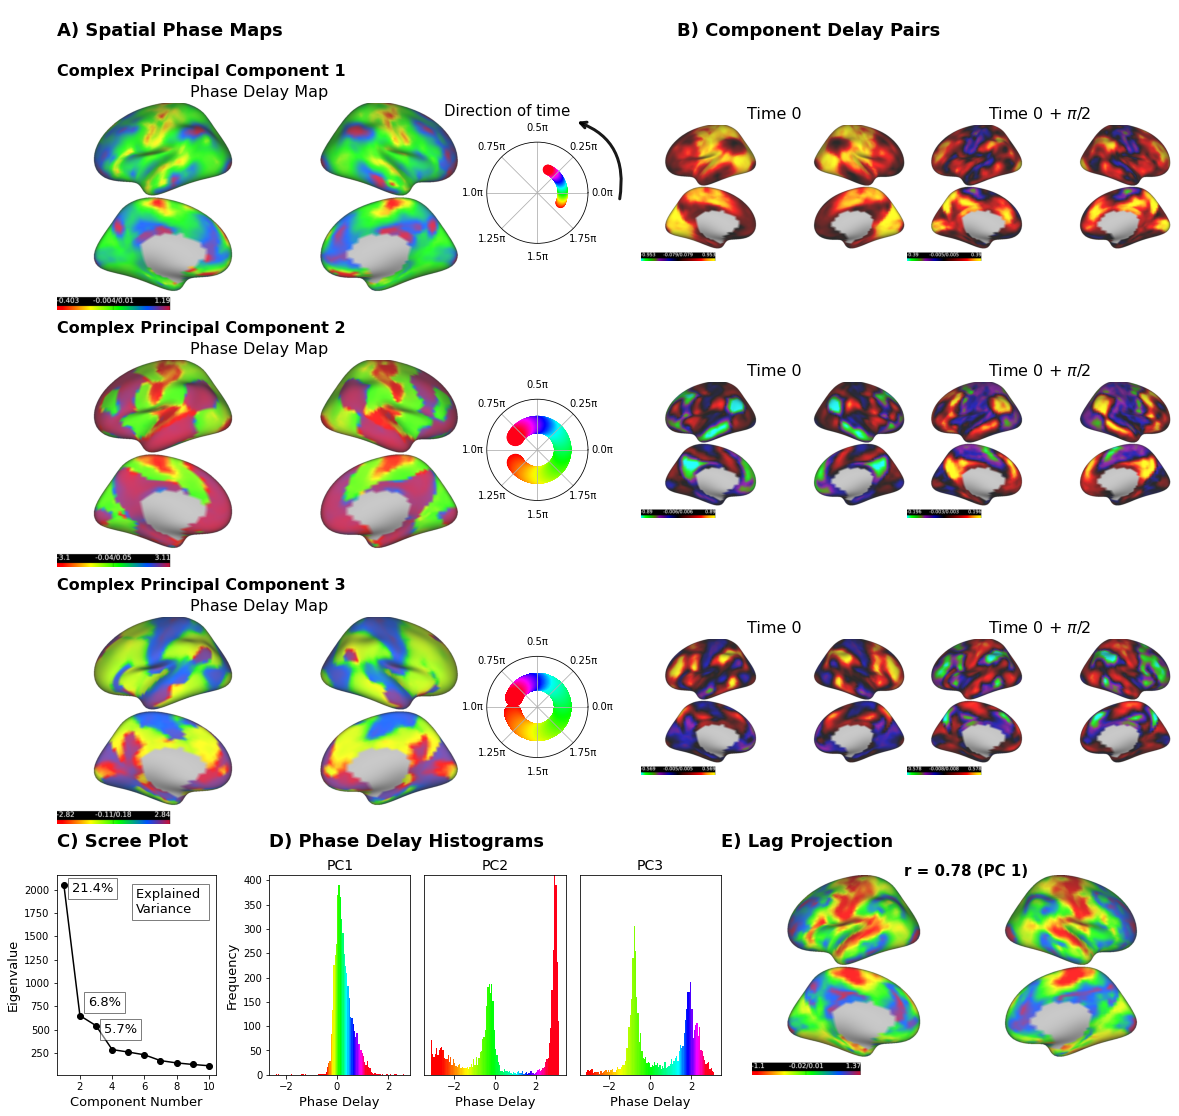

In [19]:
eigs = pickle.load(open('demo_files/pca_complex_eigenvalues.pkl', 'rb'))
exp_var = [eig/(n_vertices*2) for eig in eigs]
_, pca_comps, _ = pull_cifti_data(load_cifti('demo_files/pca_rest_complex_ang.dtseries.nii'))
_, lag_proj, _ = pull_cifti_data(load_cifti('demo_files/lag_projection.dtseries.nii'))
zero_mask = np.std(pca_comps, axis=0) > 0
pca_comps = pca_comps[:, zero_mask]
lag_proj = lag_proj[:, zero_mask][0,:]

ang_corr = np.corrcoef(pca_comps[0,:], lag_proj)[0,1]

hsv_cmap = plt.get_cmap('hsv')
fig = plt.figure(figsize=(20,19), constrained_layout=False)
crop_width = (35, 200)
crop_height = (5,15)
gspec = fig.add_gridspec(5,2, hspace=0.2, wspace=0.1, height_ratios=[0.005,0.25,0.25,0.25,0.25])

g_title = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[0,:], wspace=0.25)
title_ax = fig.add_subplot(g_title[0,0])
title_ax.set_title('A) Spatial Phase Maps', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')

title_ax = fig.add_subplot(g_title[0,1])
title_ax.set_title('B) Component Delay Pairs', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')

g_sub0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[1,0], wspace=0.1, 
                                          hspace=0, width_ratios=[0.8,0.2])
ax = fig.add_subplot(g_sub0[0,0])
img = mpimg.imread('demo_files/pca_rest_complex_comp0_ang_hsv.png')
ax.set_title('Phase Delay Map', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
box = ax.get_position()
box.y0 = box.y0 - 0.01
box.y1 = box.y1 - 0.01
ax.set_position(box)
xval = np.arange(-0.42, 1.16, 0.01)
yval = np.ones_like(xval)
hsv_cmap_shift0 = shiftedColorMap(hsv_cmap, midpoint=0.5)
norm0 = colors.Normalize(-0.42, 1.16)
ax = plt.subplot(g_sub0[0,1], polar=True)
ax.scatter(xval, yval, c=xval, s=100, cmap=hsv_cmap_shift0, norm=norm0, linewidths=0)
ax.set_yticks([])
convert_polar_xticks_to_radians(ax)

g_sub1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[2,0], wspace=0.1, 
                                          hspace=0, width_ratios=[0.8,0.2])
ax = fig.add_subplot(g_sub1[0,0])
img = mpimg.imread('demo_files/pca_rest_complex_comp1_ang_hsv.png')
ax.set_title('Phase Delay Map', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
box = ax.get_position()
box.y0 = box.y0 - 0.01
box.y1 = box.y1 - 0.01
ax.set_position(box)
xval = np.arange(-2.62, 2.64, 0.01)
yval = np.ones_like(xval)
hsv_cmap_shift1 = shiftedColorMap(hsv_cmap, midpoint=0.7)
norm1 = colors.Normalize(-2.62, 2.64)
ax = plt.subplot(g_sub1[0,1], polar=True)
ax.scatter(xval, yval, c=xval, s=300, cmap=hsv_cmap_shift1, norm=norm1, linewidths=0)
ax.set_yticks([])
convert_polar_xticks_to_radians(ax)


g_sub2 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[3,0], wspace=0.1, 
                                          hspace=0, width_ratios=[0.8,0.2])
ax = fig.add_subplot(g_sub2[0,0])
img = mpimg.imread('demo_files/pca_rest_complex_comp2_ang_hsv.png')
ax.set_title('Phase Delay Map', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
box = ax.get_position()
box.y0 = box.y0 - 0.01
box.y1 = box.y1 - 0.01
ax.set_position(box)
xval = np.arange(-2.92, 2.77, 0.001)
yval = np.ones_like(xval)
hsv_cmap_shift2 = shiftedColorMap(hsv_cmap, midpoint=0.75)
norm2 = colors.Normalize(-2.92, 2.77)
ax = plt.subplot(g_sub2[0,1], polar=True)
ax.scatter(xval, yval, c=xval, s=300, cmap=hsv_cmap_shift2, norm=norm2, linewidths=0)
ax.set_yticks([])
convert_polar_xticks_to_radians(ax)

g_sub0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[1,1], wspace=0, hspace=0)
ax = fig.add_subplot(g_sub0[0,0])
img = mpimg.imread('demo_files/pca_rest_complex_comp0_real.png')
ax.set_title('Time 0', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax = fig.add_subplot(g_sub0[0,1])
img = mpimg.imread('demo_files/pca_rest_complex_comp0_imag.png')
ax.set_title(r'Time 0 + $\pi/2$', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

g_sub1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[2,1], wspace=0, hspace=0)
ax = fig.add_subplot(g_sub1[0,0])
img = mpimg.imread('demo_files/pca_rest_complex_comp1_real.png')
ax.set_title('Time 0', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax = fig.add_subplot(g_sub1[0,1])
img = mpimg.imread('demo_files/pca_rest_complex_comp1_imag.png')
ax.set_title(r'Time 0 + $\pi/2$', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

g_sub2 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[3,1], wspace=0, hspace=0)
ax = fig.add_subplot(g_sub2[0,0])
img = mpimg.imread('demo_files/pca_rest_complex_comp2_real.png')
ax.set_title('Time 0', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax = fig.add_subplot(g_sub2[0,1])
img = mpimg.imread('demo_files/pca_rest_complex_comp2_imag.png')
ax.set_title(r'Time 0 + $\pi/2$', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

title_ax = fig.add_subplot(gspec[1,:])
title_ax.set_title('Complex Principal Component 1', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')

title_ax = fig.add_subplot(gspec[2,:])
title_ax.set_title('Complex Principal Component 2', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')

title_ax = fig.add_subplot(gspec[3,:])
title_ax.set_title('Complex Principal Component 3', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')

ax.annotate('Direction of time',
            xy=(0.525,0.82),  
            xytext=(0.43, 0.9),    
            xycoords='figure fraction',
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', arrowstyle='<-', connectionstyle="angle3, angleA=0, angleB=80", alpha = 0.9, linewidth=3),
            fontsize=15,
            horizontalalignment='center',
            verticalalignment='center',
            bbox=dict(pad=5, facecolor="none", edgecolor="none")
            )

g_sub4 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gspec[4,:], wspace=0.1, hspace=0.2, 
                                          width_ratios=[0.15,0.85], height_ratios=[0.01,0.99])

title_ax = fig.add_subplot(g_sub4[0,0])
title_ax.set_title('C) Scree Plot', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')

ax = fig.add_subplot(g_sub4[1,0])
# ax.set_aspect(0.01)
ax.plot(list(range(1,11)), eigs, '-o', color='black')
ax.set_xlabel('Component Number', fontsize=13)
ax.set_ylabel('Eigenvalue', fontsize=13)
x_adj = 0.5
y_adj = [-80,100,-80]
for i in range(3):
    ax.text((i+1)+x_adj,eigs[i]+y_adj[i], 
            r'{}%'.format(np.round(exp_var[i]*100,1)), 
            fontsize=13, bbox=dict(facecolor='white', alpha=0.5))
ax.text(5.5, 1750, 'Explained \nVariance', fontsize=13, bbox=dict(facecolor='white', alpha=0.5))

g_sub4_0 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=g_sub4[:,1], wspace=0, hspace=0.2, height_ratios=[0.01,0.99])
g_sub4_00 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub4_0[1,0], wspace=0.1, hspace=0)
g_sub4_01 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=g_sub4_0[1,1])

title_ax = fig.add_subplot(g_sub4_0[0,0])
title_ax.set_title('D) Phase Delay Histograms', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')
title_ax = fig.add_subplot(g_sub4_0[0,1])
title_ax.set_title('E) Lag Projection', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')

ax = fig.add_subplot(g_sub4_00[0])
ax.set_title('PC1', fontsize=14)
ax.set_xlabel('Phase Delay', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13)
ax.set_ylim(0,410)
sm = ScalarMappable(norm=norm0, cmap=hsv_cmap_shift0)
n, bins, patches = ax.hist(pca_comps[0,:], bins=100)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    color = sm.to_rgba(c)
    p.set_facecolor(color)
    
ax = fig.add_subplot(g_sub4_00[1])
ax.set_title('PC2', fontsize=14)
ax.set_xlabel('Phase Delay', fontsize=13)
ax.set_yticks([])
ax.set_ylim(0,410)
sm = ScalarMappable(norm=norm1, cmap=hsv_cmap_shift1)
n, bins, patches = ax.hist(pca_comps[1,:], bins=100)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    color = sm.to_rgba(c)
    p.set_facecolor(color)
    
ax = fig.add_subplot(g_sub4_00[2])
ax.set_title('PC3', fontsize=14)
ax.set_xlabel('Phase Delay', fontsize=13)
ax.set_yticks([])
ax.set_ylim(0,410)
sm = ScalarMappable(norm=norm2, cmap=hsv_cmap_shift2)
n, bins, patches = ax.hist(pca_comps[2,:], bins=100)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    color = sm.to_rgba(c)
    p.set_facecolor(color)

img = mpimg.imread('demo_files/lag_projection_hsv.png')
ax = fig.add_subplot(g_sub4_01[0])
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax.annotate(f'r = {round(ang_corr,2)} (PC 1)', (0.39,1), xycoords='axes fraction', fontsize=15, fontweight='bold')

plt.savefig('results/figures/cpca', bbox_inches='tight')
# plt.show()

### Figure 2 Caption

(PC= principal component). Time-lag structure of the first three complex principal components. A) Phase delay maps of the first three complex principal components. The phase lag map are expressed in radians (0 to 2) and are read negative to positive, or counter-clockwise: cortical vertices with negative phase values occur before vertices with positive values. B) Each complex principal component presented at two phase points of its time-lag structure - the real part (t=0) and imaginary part (t=0+2) of the complex component, corresponding to the original signal and its Hilbert transform. The phase delay maps and the two phase points illustrate the time-lag dynamics of each complex principal component as it unfolds over time. C) The eigenvalue by component number plot (i.e. scree plot) used to determine the number of components to extract. As with the original PCA solution (Figure 1A), there are clear elbows in the plot after one and three components, indicating a preferred solution of one or three principal components (three were chosen). D) The phase value histogram of each complex principal component phase delay map. The first component histogram is unimodal, and the second and third components are bimodal. E) Cortical lag projection map. The cortical lag projection map represents the average time-lag difference between each vertex of the cortex. The colormap reads the same as the phase delay map of the complex principal components: negative values precede positive values in time. The spatial distribution of average time-lags in the cortical lag projection map corresponds closely to the phase delay map of the first complex principal component (r = 0.78). 

# <b>Figure 3 -  Spatiotemporal Dynamics of Time-lag Structures.</b>

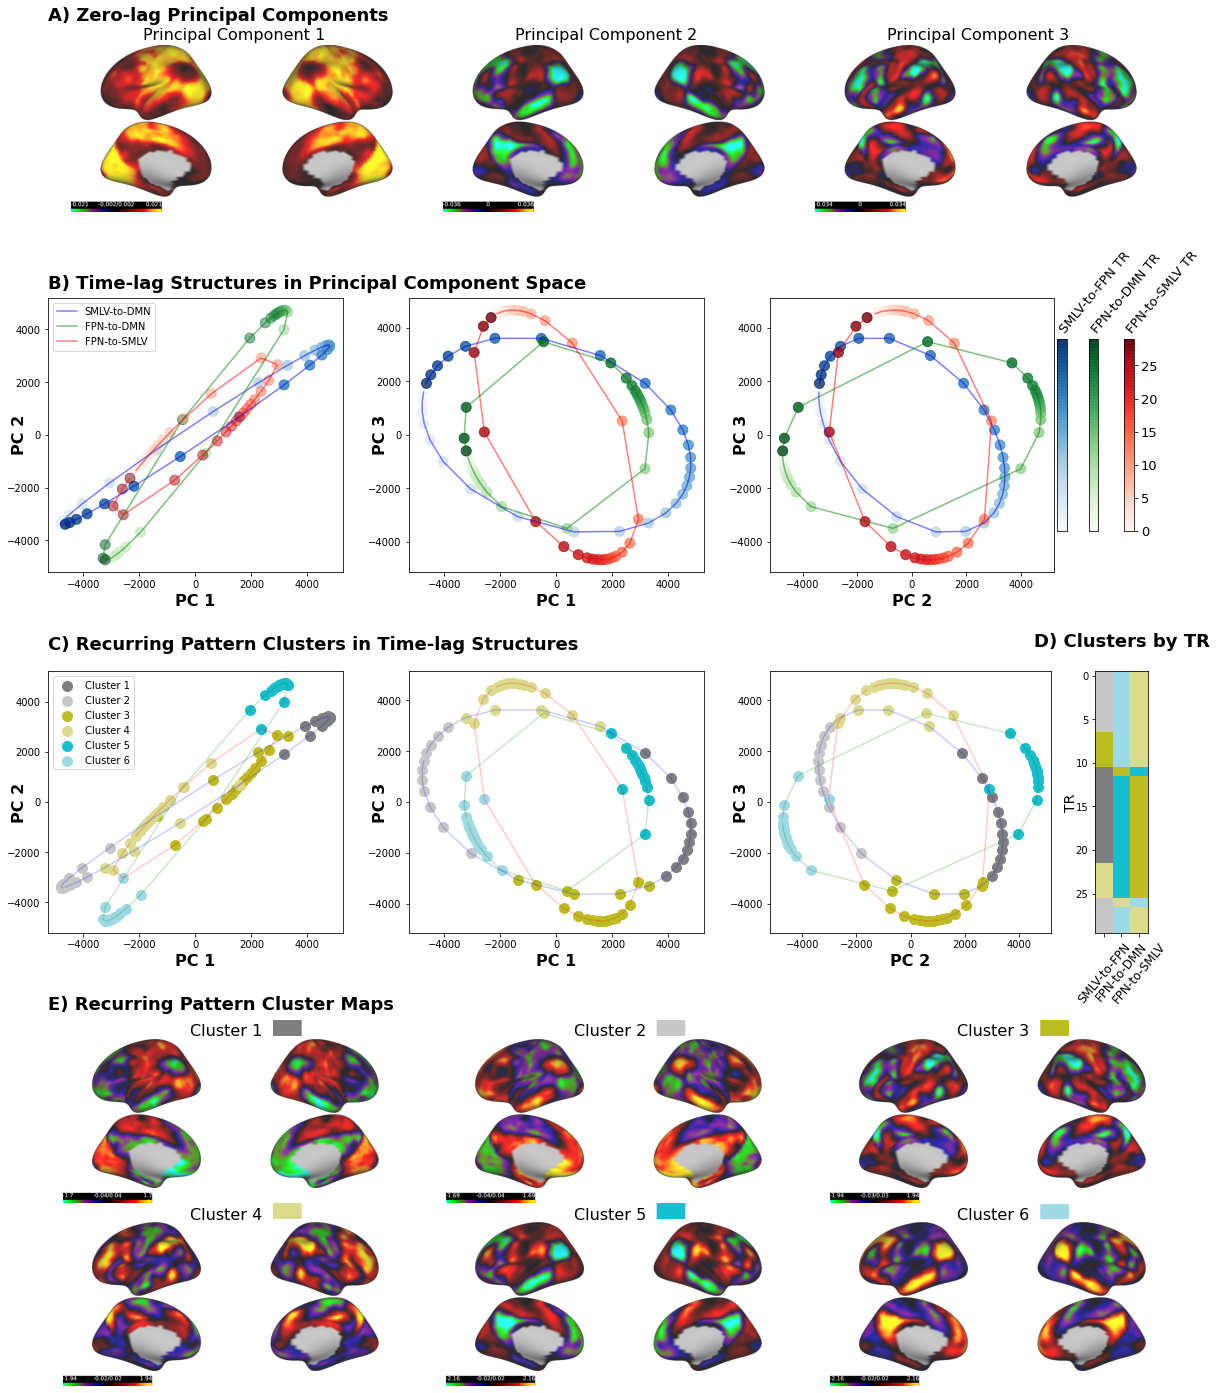

In [402]:
V = pickle.load(open('demo_files/pca_eigen.pkl', 'rb')) # X = USV
V = zscore(V.T).T
_, cpca_comp0, n_time = pull_cifti_data(load_cifti('results/cpca_comp0_recon.dtseries.nii'))
_, cpca_comp1, n_time = pull_cifti_data(load_cifti('results/cpca_comp1_recon.dtseries.nii'))
_, cpca_comp2, n_time = pull_cifti_data(load_cifti('results/cpca_comp2_recon.dtseries.nii'))

zero_mask = np.std(cpca_comp0, axis=0) > 0

cpca_comp0 = zscore(cpca_comp0[:, zero_mask].copy().T).T
cpca_comp1 = zscore(cpca_comp1[:, zero_mask].copy().T).T
cpca_comp2 = zscore(cpca_comp2[:, zero_mask].copy().T).T

cpca_comp0_proj = cpca_comp0 @ V.T
cpca_comp1_proj = cpca_comp1 @ V.T
cpca_comp2_proj = cpca_comp2 @ V.T

fig = plt.figure(figsize=(20,25), constrained_layout=False)
crop_width = (35, 200)
crop_height = (5,15)

gspec = fig.add_gridspec(4,1, hspace=0.3, wspace=0, 
                         height_ratios=[0.2,0.3,0.3,0.4])

g_sub0 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gspec[0], wspace=0, 
                                          hspace=0.2, height_ratios=[0.01,0.99])
title_ax = fig.add_subplot(g_sub0[0,:])
title_ax.set_title('A) Zero-lag Principal Components', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')
ax = fig.add_subplot(g_sub0[1,0])
img = mpimg.imread('demo_files/pca_rest_comp0.png')
ax.set_title('Principal Component 1', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

ax = fig.add_subplot(g_sub0[1,1])
img = mpimg.imread('demo_files/pca_rest_comp1.png')
ax.set_title('Principal Component 2', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

ax = fig.add_subplot(g_sub0[1,2])
img = mpimg.imread('demo_files/pca_rest_comp2.png')
ax.set_title('Principal Component 3', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

g_sub1 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gspec[1], wspace=0.2, 
                                          hspace=0, height_ratios=[0.01,0.99],
                                          width_ratios=[0.3,0.3,0.4])
title_ax = fig.add_subplot(g_sub1[0,:])
title_ax.set_title('B) Time-lag Structures in Principal Component Space', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')
t = np.arange(30)
ax = fig.add_subplot(g_sub1[1,0])
ax.set_xlabel('PC 1', fontsize=16, fontweight='bold')
ax.set_ylabel('PC 2', fontsize=16, fontweight='bold', labelpad=-20)
ax.scatter(cpca_comp0_proj[:,0], cpca_comp0_proj[:,1], c=t, 
           cmap='Blues', s=100, alpha=0.8)
ax.plot(cpca_comp0_proj[:,0], cpca_comp0_proj[:,1], alpha=0.5, color='b',
        label='SMLV-to-DMN')
ax.scatter(cpca_comp1_proj[:,0], cpca_comp1_proj[:,1], c=t, 
           cmap='Greens', s=100, alpha=0.5)
ax.plot(cpca_comp1_proj[:,0], cpca_comp1_proj[:,1], alpha=0.5, color='g',
        label='FPN-to-DMN')
ax.scatter(cpca_comp2_proj[:,0], cpca_comp2_proj[:,1], c=t, 
           cmap='Reds', s=100, alpha=0.5)
ax.plot(cpca_comp2_proj[:,0], cpca_comp2_proj[:,1], alpha=0.5, color='r', 
        label='FPN-to-SMLV')
ax.legend()

ax = fig.add_subplot(g_sub1[1,1])
ax.set_xlabel('PC 1', fontsize=16, fontweight='bold')
ax.set_ylabel('PC 3', fontsize=16, fontweight='bold', labelpad=-20)
ax.scatter(cpca_comp0_proj[:,0], cpca_comp0_proj[:,2], c=t, 
           cmap='Blues', s=100, alpha=0.8)
ax.plot(cpca_comp0_proj[:,0], cpca_comp0_proj[:,2], alpha=0.5, color='b')
ax.scatter(cpca_comp1_proj[:,0], cpca_comp1_proj[:,2], c=t, 
           cmap='Greens', s=100, alpha=0.8)
ax.plot(cpca_comp1_proj[:,0], cpca_comp1_proj[:,2], alpha=0.5, color='g')
ax.scatter(cpca_comp2_proj[:,0], cpca_comp2_proj[:,2], c=t, 
           cmap='Reds', s=100, alpha=0.8)
ax.plot(cpca_comp2_proj[:,0], cpca_comp2_proj[:,2], alpha=0.5, color='r')

ax = fig.add_subplot(g_sub1[1,2])
ax.set_xlabel('PC 2', fontsize=16, fontweight='bold')
ax.set_ylabel('PC 3', fontsize=16, fontweight='bold', labelpad=-20)
scatter1 = ax.scatter(cpca_comp0_proj[:,1], cpca_comp0_proj[:,2], c=t, 
                      cmap='Blues', s=100, alpha=0.8)
ax.plot(cpca_comp0_proj[:,1], cpca_comp0_proj[:,2], alpha=0.5, color='b')
scatter2 = ax.scatter(cpca_comp1_proj[:,1], cpca_comp1_proj[:,2], c=t, 
                      cmap='Greens', s=100, alpha=0.8)
ax.plot(cpca_comp1_proj[:,1], cpca_comp1_proj[:,2], alpha=0.5, color='g')
scatter3 = ax.scatter(cpca_comp2_proj[:,1], cpca_comp2_proj[:,2], c=t, 
                      cmap='Reds', s=100, alpha=0.8)
ax.plot(cpca_comp2_proj[:,1], cpca_comp2_proj[:,2], alpha=0.5, color='r')

cbar = plt.colorbar(scatter3, shrink=0.7, pad=0, ax=ax, fraction=0.1)
cbar.ax.set_title('FPN-to-SMLV TR', loc='left', rotation=50, fontsize=13)
cbar.ax.tick_params(labelsize=13)
cbar = plt.colorbar(scatter2, shrink=0.7, pad=0, ax=ax, fraction=0.1)
cbar.ax.set_title('FPN-to-DMN TR', loc='left', rotation=50, fontsize=13)
cbar.set_ticks([])
cbar = plt.colorbar(scatter1, shrink=0.7, pad=0.01, ax=ax, fraction=0.1)
cbar.ax.set_title('SMLV-to-FPN TR', loc='left', rotation=50, fontsize=13)
cbar.set_ticks([])

cpca_comp_all = np.vstack([zscore(cpca_comp0.T).T, zscore(cpca_comp1.T).T, zscore(cpca_comp2.T).T])
cpca_comp_all_proj = np.vstack([cpca_comp0_proj, cpca_comp1_proj, cpca_comp2_proj])
kmeans = KMeans(n_clusters=6, n_init=10, random_state=0)
kmeans.fit(cpca_comp_all)

g_sub2 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gspec[2], wspace=0.2, 
                                          hspace=0.1, width_ratios=[0.3,0.3,0.4],
                                          height_ratios=[0.01,0.99])
title_ax = fig.add_subplot(g_sub2[0,:])
title_ax.set_title('C) Recurring Pattern Clusters in Time-lag Structures', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')
ax0 = fig.add_subplot(g_sub2[1,0])
ax1 = fig.add_subplot(g_sub2[1,1])
ax2 = fig.add_subplot(g_sub2[1,2])
ax0.set_xlabel('PC 1', fontsize=16, fontweight='bold')
ax0.set_ylabel('PC 2', fontsize=16, fontweight='bold', labelpad=-20)
ax1.set_xlabel('PC 1', fontsize=16, fontweight='bold')
ax1.set_ylabel('PC 3', fontsize=16, fontweight='bold', labelpad=-20)
ax2.set_xlabel('PC 2', fontsize=16, fontweight='bold')
ax2.set_ylabel('PC 3', fontsize=16, fontweight='bold', labelpad=-20)
c_colors = [plt.cm.tab20(i) for i in [14,15,16,17,18,19]]
for c_indx, label in enumerate(np.unique(kmeans.labels_)):
    indx = np.where(kmeans.labels_==label)
    ax0.scatter(cpca_comp_all_proj[indx,0], cpca_comp_all_proj[indx,1], 
                color=c_colors[c_indx], s=100, label=f'Cluster {c_indx+1}')
    ax1.scatter(cpca_comp_all_proj[indx,0], cpca_comp_all_proj[indx,2], 
                color=c_colors[c_indx], s=100)
    ax2.scatter(cpca_comp_all_proj[indx,1], cpca_comp_all_proj[indx,2], 
                color=c_colors[c_indx], s=100)

ax0.plot(cpca_comp0_proj[:,0], cpca_comp0_proj[:,1], alpha=0.2, color='b')
ax0.plot(cpca_comp1_proj[:,0], cpca_comp1_proj[:,1], alpha=0.2, color='g')
ax0.plot(cpca_comp2_proj[:,0], cpca_comp2_proj[:,1], alpha=0.2, color='r')
ax0.legend()

ax1.plot(cpca_comp0_proj[:,0], cpca_comp0_proj[:,2], alpha=0.2, color='b')
ax1.plot(cpca_comp1_proj[:,0], cpca_comp1_proj[:,2], alpha=0.2, color='g')
ax1.plot(cpca_comp2_proj[:,0], cpca_comp2_proj[:,2], alpha=0.2, color='r')

ax2.plot(cpca_comp0_proj[:,1], cpca_comp0_proj[:,2], alpha=0.2, color='b')
ax2.plot(cpca_comp1_proj[:,1], cpca_comp1_proj[:,2], alpha=0.2, color='g')
ax2.plot(cpca_comp2_proj[:,1], cpca_comp2_proj[:,2], alpha=0.2, color='r')

labels_c0 = kmeans.labels_[:30]
labels_c1 = kmeans.labels_[30:60]
labels_c2 = kmeans.labels_[60:]
labels_df = pd.DataFrame([labels_c0, labels_c1, labels_c2]).T
cmap = colors.ListedColormap(c_colors)
bounds=[0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax2_divider = make_axes_locatable(ax2)
sub_ax2 = ax2_divider.append_axes("right", size="30%", pad="10%")
sub_ax2.imshow(labels_df, cmap=cmap)
sub_ax2.set_aspect(0.5)
sub_ax2.set_ylabel('TR', fontsize=14, labelpad=-2)
sub_ax2.set_title('D) Clusters by TR', fontsize=18, fontweight='bold', pad=25)
sub_ax2.set_xticks([0,1,2])
sub_ax2.set_xticklabels(['SMLV-to-FPN', 'FPN-to-DMN', 'FPN-to-SMLV'], fontsize=12, 
                        rotation=50, ha='center')

## Write cluster centroids to cifti files
# This cannot be done without access to data, so it is commented out
# ex_subj_file = ['data/rest/proc_3_surf_resamp/200513_LR1_rest_smooth_filt_smooth_filt_resamp.R.func.gii', 
#                 'data/rest/proc_3_surf_resamp/200513_LR1_rest_smooth_filt_smooth_filt_resamp.L.func.gii']
# hdr = load_gifti(ex_subj_file)
# write_to_gifti(kmeans.cluster_centers_, hdr, 'cpca_kmeans_N6', zero_mask)

g_sub3 = gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec=gspec[3], wspace=0.1, 
                                          hspace=0, height_ratios=[0.01,0.49,0.49])
title_ax = fig.add_subplot(g_sub3[0,:])
title_ax.set_title('E) Recurring Pattern Cluster Maps', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')
ax = fig.add_subplot(g_sub3[1,0])
img = mpimg.imread('demo_files/cpca_recon_cluster0.png')
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax_divider = make_axes_locatable(ax)
sub_ax = ax_divider.append_axes("top", size="10%", pad="2%")
sub_ax.text(0.4,0, 'Cluster 1', fontsize=16)
# add a fancy box
fancybox = FancyBboxPatch((0.68,0),0.05,1,linewidth=1,
                          edgecolor='none',facecolor=c_colors[0], 
                          boxstyle=BoxStyle("Round", pad=0.02, rounding_size=0.015))
sub_ax.add_patch(fancybox)
sub_ax.axis('off')


ax = fig.add_subplot(g_sub3[1,1])
img = mpimg.imread('demo_files/cpca_recon_cluster1.png')
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax_divider = make_axes_locatable(ax)
sub_ax = ax_divider.append_axes("top", size="10%", pad="2%")
sub_ax.text(0.4,0, 'Cluster 2', fontsize=16)
# add a fancy box
fancybox = FancyBboxPatch((0.68,0),0.05,1,linewidth=1,
                          edgecolor='none',facecolor=c_colors[1], 
                          boxstyle=BoxStyle("Round", pad=0.02, rounding_size=0.015))
sub_ax.add_patch(fancybox)
sub_ax.axis('off')

ax = fig.add_subplot(g_sub3[1,2])
img = mpimg.imread('demo_files/cpca_recon_cluster2.png')
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax_divider = make_axes_locatable(ax)
sub_ax = ax_divider.append_axes("top", size="10%", pad="2%")
sub_ax.text(0.4,0, 'Cluster 3', fontsize=16)
# add a fancy box
fancybox = FancyBboxPatch((0.68,0),0.05,1,linewidth=1,
                          edgecolor='none',facecolor=c_colors[2], 
                          boxstyle=BoxStyle("Round", pad=0.02, rounding_size=0.015))
sub_ax.add_patch(fancybox)
sub_ax.axis('off')

ax = fig.add_subplot(g_sub3[2,0])
img = mpimg.imread('demo_files/cpca_recon_cluster3.png')
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax_divider = make_axes_locatable(ax)
sub_ax = ax_divider.append_axes("top", size="10%", pad="2%")
sub_ax.text(0.4,0, 'Cluster 4', fontsize=16)
# add a fancy box
fancybox = FancyBboxPatch((0.68,0),0.05,1,linewidth=1,
                          edgecolor='none',facecolor=c_colors[3], 
                          boxstyle=BoxStyle("Round", pad=0.02, rounding_size=0.015))
sub_ax.add_patch(fancybox)
sub_ax.axis('off')

ax = fig.add_subplot(g_sub3[2,1])
img = mpimg.imread('demo_files/cpca_recon_cluster4.png')
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax_divider = make_axes_locatable(ax)
sub_ax = ax_divider.append_axes("top", size="10%", pad="2%")
sub_ax.text(0.4,0, 'Cluster 5', fontsize=16)
# add a fancy box
fancybox = FancyBboxPatch((0.68,0),0.05,1,linewidth=1,
                          edgecolor='none',facecolor=c_colors[4], 
                          boxstyle=BoxStyle("Round", pad=0.02, rounding_size=0.015))
sub_ax.add_patch(fancybox)
sub_ax.axis('off')

ax = fig.add_subplot(g_sub3[2,2])
img = mpimg.imread('demo_files/cpca_recon_cluster5.png')
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
ax_divider = make_axes_locatable(ax)
sub_ax = ax_divider.append_axes("top", size="10%", pad="2%")
sub_ax.text(0.4,0, 'Cluster 6', fontsize=16)
# add a fancy box
fancybox = FancyBboxPatch((0.68,-0.1),0.05,1,linewidth=1,
                          edgecolor='none',facecolor=c_colors[5], 
                          boxstyle=BoxStyle("Round", pad=0.02, rounding_size=0.015))
sub_ax.add_patch(fancybox)
sub_ax.axis('off')

# plt.show()
plt.savefig('results/figures/cpca_dynamics.png')


### Figure 3 Caption

(PC = Principal Component) Illustration of the progression of BOLD activity over time in each time-lag structure. A) The spatial weights for the first three principal components from zero-lag PCA (Figure 1). For visualization of spatiotemporal dynamics, the time points (N=30) from each time-lag structure were projected onto the 3-dimensional space formed by the first three principal components. B) Two-dimensional slices of each time-lag structure in the 3-dimensional principal component space - PC1-PC2, PC1-PC3, and PC2-PC3 spaces. The time points of the SMLV-to-FPN, FPN-to-DMN, and FPN-to-SMLV are displayed as blue, green and red points, respectively. Consecutive time points of each time-lag structure are linked by lines. The time points of each time-lag structure are colored from light to darker to visualize the progression of time (N=30). The score of each time point on a given principal component is proportional to the Pearson correlation coefficient between the BOLD activity at that time point with the spatial weights of the principal component. In other words, time points with high positive scores on the first principal component indicate a strong positive correlation between the BOLD activity at that time point and the spatial weights of the first principal component. Examination of the movement of time points over the progression of a time-lag structure provides information regarding the spatiotemporal dynamics of the time-lag structure. C) The same two-dimensional slices of each time-lag structure in the 3-dimensional principal component space colored according to their cluster assignment by a K-Means clustering algorithm. K-Means clustering was used to identify recurring spatial patterns of BOLD activity across time points of the three time-lag structures. Six clusters were estimated. D) The cluster assignments (color) by time (y-axis) of each time-lag structure (x-axis). Note, that the same cluster assignment can occur across more than one time-lag structure. D) The cluster centroids from the K-means clustering algorithm, corresponding to the average spatial pattern of BOLD activity for the time points that belong to that cluster. 

# <b>Movie 1 -  Spatiotemporal Visualization of Time-lag Structures.</b>

In [196]:
%%HTML
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/time_lag_structures.mp4"
        type="video/mp4"
</video>

## Movie 1 Caption

Spatiotemporal reconstruction of all three time-lag structures displayed as movies in the following order - SMLV-to-FPN, FPN-to-DMN, FPN-to-SMLV. The time points are equally-spaced phase samples (N=30) of the spatiotemporal reconstruction. The phase of each time point is displayed in radians in the top left. In the bottom of the panel, the time points of each time-lag structure are displayed in three-dimensional principal component space (Figure 3). Two-dimensional slices of the three principal component space are displayed as the three 2-dimensional plots. The time points of each time-lag structure are colored in a cyclical color map (light to dark to light). The movement of the time-lag structure through this space is illustrated by a moving red dot from time point-to-time point in synchronization with the spatiotemporal reconstruction above.

# <b> Movie 2. Dynamic Visualization of the Quasiperiodic Pattern, SMLV-to-FPN, and Global Signal.</b>

In [197]:
%%HTML
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/qpp_comparison.mp4"
        type="video/mp4"
</video>

## Movie 2 Caption

The 30 time points (TR=0.72s) of the SMLV-to-FPN, QPP and peak-average global signal displayed as a movie. The film rotates from one sequence to the other in order. The time index of each sequence is displayed in the top left. The time points of the SMLV-to-FPN are equally-spaced phase samples (N=30) of the spatiotemporal reconstruction of the SMLV-to-FPN, and are displayed in radians. The global signal visualization concatenates the left and right windows (w=15TRs) of the global signal peak-average. The time points of the global signal visualization begin at t=-15, corresponding to 15 TRs pre-peak, and proceed to t=15, corresponding to 15TRs post-peak.

# <b>Figure 4 - Relationship Between the FPN-to-DMN and Anti-Correlated Functional Connectivity Topographies.</b>

<ipython-input-2-198a7b00c62a>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


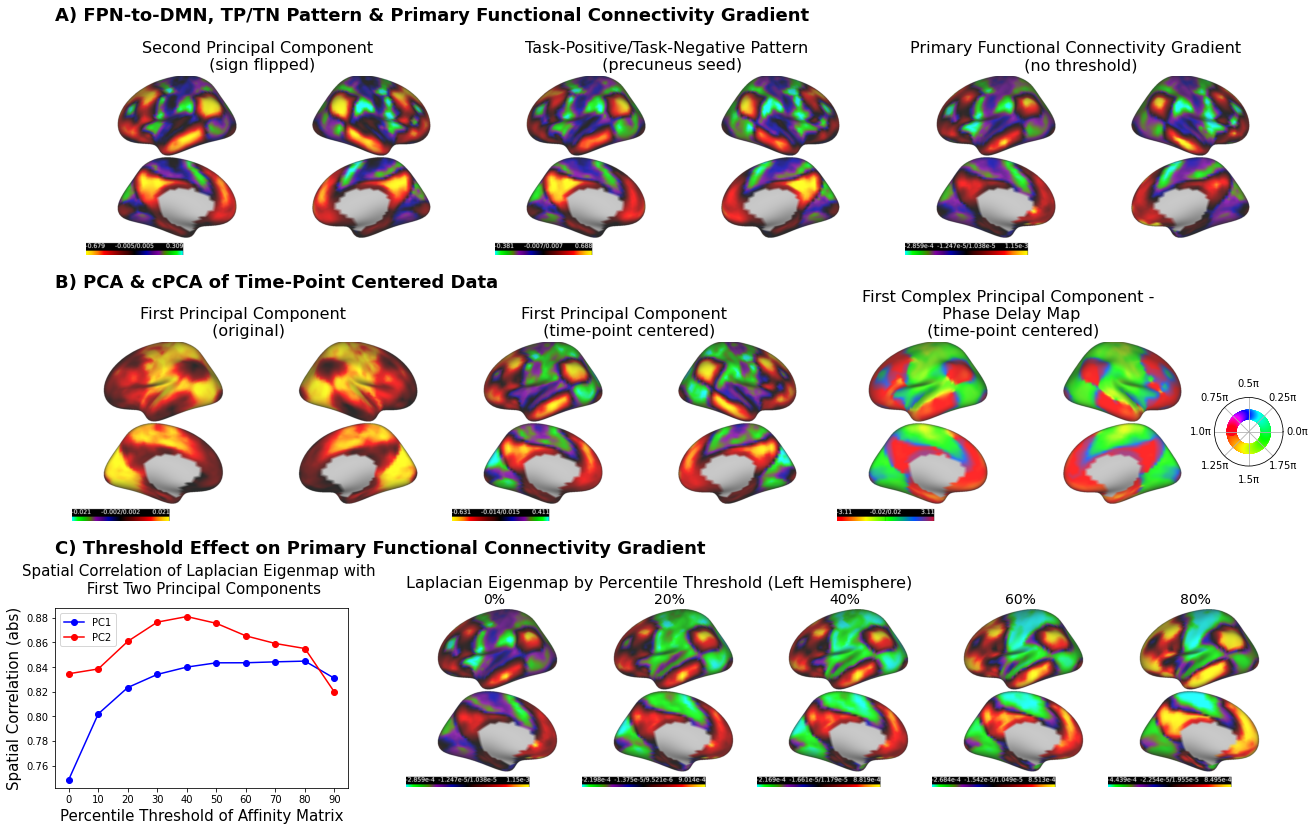

In [194]:
gs_signal = pickle.load(open('demo_files/gs_results.pkl', 'rb'))
comp_ts = pickle.load(open('demo_files/pca_complex_ts.pkl', 'rb'))
comp0_ts = np.real(comp_ts[:,0])

gs_comp0_corr = np.corrcoef(gs_signal, comp0_ts)[0,1]

eigenmap_indx = np.arange(0,100,10)
eigenmaps = []
for indx in eigenmap_indx:
    _, eigenmap, _ = pull_cifti_data(load_cifti(f'demo_files/eigenmap_p{indx}.dtseries.nii'))
    eigenmaps.append(eigenmap[0,:])
eigenmaps_array = np.array(eigenmaps)
zero_mask = np.std(eigenmaps_array, axis=0) > 0
eigenmaps_array = eigenmaps_array[:,zero_mask].copy()

_, pca_maps, _ = pull_cifti_data(load_cifti(f'demo_files/pca_rest.dtseries.nii'))
pca_maps = pca_maps[:2, zero_mask].copy()

pca_eigenmap_corr = np.corrcoef(pca_maps, eigenmaps_array)[:2, 2:]

fig = plt.figure(figsize=(22,14), constrained_layout=False)
crop_width = (35, 200)
crop_height = (5,10)

gspec = fig.add_gridspec(6,1, hspace=0.4, wspace=0, 
                         height_ratios=[0.02,0.33,0.02,0.33,0.02,0.33])

title_ax = fig.add_subplot(gspec[0,:])
title_ax.set_title('A) FPN-to-DMN, TP/TN Pattern & Primary Functional Connectivity Gradient', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')
g_sub0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gspec[1],
                                         wspace=0)
ax = fig.add_subplot(g_sub0[0])
img = mpimg.imread('demo_files/pca_rest_comp1_flip.png')
ax.set_title(f'Second Principal Component \n (sign flipped)', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

ax = fig.add_subplot(g_sub0[1])
img = mpimg.imread('demo_files/fc_map_precuneus_gs_nonsymmetric.png')
ax.set_title(f'Task-Positive/Task-Negative Pattern \n (precuneus seed)', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

ax = fig.add_subplot(g_sub0[2])
img = mpimg.imread('demo_files/eigenmap_p0_comp0.png')
ax.set_title(f'Primary Functional Connectivity Gradient \n (no threshold)', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')


title_ax = fig.add_subplot(gspec[2,:])
title_ax.set_title('B) PCA & cPCA of Time-Point Centered Data', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')
g_sub1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[3], wspace=0, width_ratios=[0.62,0.38])
g_sub1_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub1[0], wspace=0)
g_sub1_1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub1[1], wspace=0.04, 
                                            width_ratios=[0.85,0.15])

ax = fig.add_subplot(g_sub1_0[0])
img = mpimg.imread('demo_files/pca_rest_comp0.png')
ax.set_title(f'First Principal Component \n (original)', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

ax = fig.add_subplot(g_sub1_0[1])
img = mpimg.imread('demo_files/pca_rest_comp0_tmode_flip.png')
ax.set_title(f'First Principal Component \n (time-point centered)', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')

hsv_cmap = plt.get_cmap('hsv')
ax = fig.add_subplot(g_sub1_1[0])
img = mpimg.imread('demo_files/pca_rest_complex_tmode_comp0_ang_hsv.png')
ax.set_title('First Complex Principal Component - \n Phase Delay Map \n (time-point centered)', fontsize=16)
ax.imshow(cropImage(img,crop_width,crop_height))
ax.axis('off')
xval = np.arange(-3.11, 3.11, 0.01)
yval = np.ones_like(xval)
hsv_cmap_shift1 = shiftedColorMap(hsv_cmap, midpoint=0.7)
norm1 = colors.Normalize(-3.11, 3.11)
ax = plt.subplot(g_sub1_1[1], polar=True)
ax.scatter(xval, yval, c=xval, s=100, cmap=hsv_cmap_shift1, norm=norm1, linewidths=0)
ax.set_yticks([])
convert_polar_xticks_to_radians(ax)

title_ax = fig.add_subplot(gspec[4,:])
title_ax.set_title('C) Threshold Effect on Primary Functional Connectivity Gradient', 
                   fontsize=18, fontweight='bold', loc='left')
title_ax.axis('off')
g_sub2 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[5], wspace=0.1, width_ratios=[0.25,0.75])
g_sub2_0 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=g_sub2[0], wspace=0)
g_sub2_1 = gridspec.GridSpecFromSubplotSpec(1,5, subplot_spec=g_sub2[1], wspace=0)

ax = fig.add_subplot(g_sub2_0[0])
ax.plot(eigenmap_indx, np.abs(pca_eigenmap_corr[0,:]), marker='o',color='b', label='PC1')
ax.plot(eigenmap_indx, np.abs(pca_eigenmap_corr[1,:]), marker='o',color='r', label='PC2')
ax.legend()
ax.set_xticks(eigenmap_indx)
ax.set_title('Spatial Correlation of Laplacian Eigenmap with \n First Two Principal Components', fontsize=15, pad=15)
ax.set_xlabel('Percentile Threshold of Affinity Matrix', fontsize=15)
ax.set_ylabel('Spatial Correlation (abs)', fontsize=15)

crop_width2 = (35, 1200)
crop_height2 = (5,20)

sub_title_ax = fig.add_subplot(g_sub2_1[0,:])
sub_title_ax.set_title('Laplacian Eigenmap by Percentile Threshold (Left Hemisphere)', 
                   fontsize=16, loc='left')
sub_title_ax.axis('off')
box = sub_title_ax.get_position()
box.y0 = box.y0 + 0.015
box.y1 = box.y1 + 0.015
sub_title_ax.set_position(box)

eigenmap_indx2 = np.arange(0,100,20)
for i, indx in enumerate(eigenmap_indx2):
    ax = fig.add_subplot(g_sub2_1[i])
    img = mpimg.imread(f'demo_files/eigenmap_p{indx}_comp0.png')
    ax.set_title(f'{indx}%', fontsize=14)
    ax.imshow(cropImage(img,crop_width2,crop_height2))
    ax.axis('off')
# plt.show()
plt.savefig('results/figures/fpn_to_dmn.png')

## Figure 4 Caption

A) From right to left, the FPN-to-DMN, task-positive/task-negative (TP/TN) pattern, and the PG represented by the spatial weights of the second principal component from zero-lag PCA (sign flipped for consistency), seed-based correlation map (precuneus seed), and first Laplacian eigenmap with no thresholding of the affinity matrix, respectively. Note, the color mapping of each brain map is non-symmetric to emphasize the smaller negative values within the FPN. As can be observed visually, similar spatial patterns are produced from all three analyses - FPN-to-DMN:TP/TN (r =0.96) and FPN-to-DMN:PG (r = 0.83). B) From right to left, the first principal component from non-time-centered BOLD time courses, the first principal component of time-centered BOLD time courses, and the first complex principal component phase delay map from time-centered BOLD time courses. As can be observed visually, time-point centering of BOLD time courses replaces the original unipolar first principal component (left) with a bipolar (anti-correlated) principal component (middle). In the same manner, the first complex principal component of cPCA of time-centered BOLD time courses (right) exhibits a phase delay map resembling the phase delay map of the second complex principal component from cPCA of non-time-centered BOLD time courses (Figure 2). C) The effect of functional connectivity (FC) matrix percentile thresholding on the resulting spatial weights of the PG, computed as the first eigenmap of the Laplacian Eigenmap algorithm (only left hemisphere presented for space). At zero to low-thresholding of the FC matrix, the first Laplacian Eigenmap resembles the second principal component of non-time-centered BOLD time courses. As the threshold is raised, the spatial weights of vertices within the FPN, DMN and SMLV complex become more uniform, and the spatial weights of the vertices within the FPN fall to zero. At higher thresholds this results in an Eigenmap that resembles the first principal component of non-time-centered BOLD time courses.


# <b> Figure 5 - Comparison of Original and Reconstructed Functional Connectivity Matrices. </b>

/Users/taylorbolt/opt/miniconda3/envs/bold_waves/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


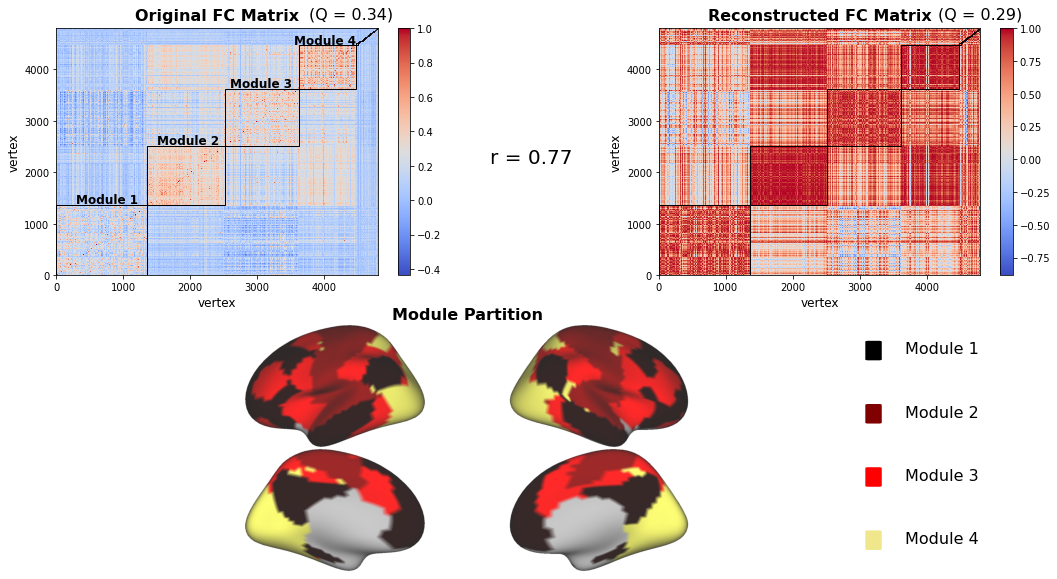

In [5]:
pca_res = pickle.load(open('results/pca_rest_complex_results.pkl', 'rb'))['pca']
orig_corr = pickle.load(open('results/fc_matrix_results.pkl', 'rb'))
U = pca_res['U'][:,:3]
s = np.diag(pca_res['s'][:3])
Va = pca_res['Va'][:3,:]
recon_ts = np.real(U @ s @ Va)
recon_corr = np.corrcoef(recon_ts.T)

orig_tril = orig_corr[np.tril_indices(orig_corr.shape[0], k=1)]
recon_tril = recon_corr[np.tril_indices(recon_corr.shape[0],k=1)]
orig_recon_corr = np.corrcoef(orig_tril, recon_tril)[0,1]

orig_corr_adj = orig_corr.copy()
recon_corr_adj = recon_corr.copy()
np.fill_diagonal(orig_corr_adj, 0)
np.fill_diagonal(recon_corr_adj, 0)
orig_corr_adj[orig_corr_adj < np.percentile(orig_corr_adj, 80)] = 0
recon_corr_adj[recon_corr_adj < np.percentile(recon_corr_adj, 80)] = 0

louvain = Louvain(resolution=1, random_state=0)
labels = louvain.fit_transform(orig_corr_adj)
orig_q = modularity(orig_corr_adj, labels)
recon_q = modularity(recon_corr_adj, labels)

## Write module assignments to cifti file for display
# This cannot be done without access to data, so it is commented out
# ex_subj_file = ['data/rest/proc_3_surf_resamp/200513_LR1_rest_smooth_filt_smooth_filt_resamp.R.func.gii', 
#                 'data/rest/proc_3_surf_resamp/200513_LR1_rest_smooth_filt_smooth_filt_resamp.L.func.gii']
# hdr = load_gifti(ex_subj_file)
# write_to_gifti(labels[np.newaxis, :]+1, hdr, 'louvain_modules', zero_mask)

fig = plt.figure(figsize=(18,10), constrained_layout=False)
gspec = fig.add_gridspec(2,2, wspace=0.5)
ax0 = fig.add_subplot(gspec[0])
ax1 = fig.add_subplot(gspec[1])
g_sub = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gspec[1,:], wspace=0,
                                         width_ratios=[0.05, 0.8, 0.2, 0.05])
ax2 = fig.add_subplot(g_sub[1])

plot_sorted_corr_mat(orig_corr, labels, ax0)
ax0.set_title('Original FC Matrix', fontsize=16, pad=8, fontweight='bold')
ax0.set_xlabel('vertex', fontsize=12)
ax0.set_ylabel('vertex', fontsize=12)
ax0.text(300, 1400, 'Module 1', fontweight='bold', fontsize=12)
ax0.text(1500, 2550, 'Module 2', fontweight='bold', fontsize=12)
ax0.text(2600, 3650, 'Module 3', fontweight='bold', fontsize=12)
ax0.text(3550, 4500, 'Module 4', fontweight='bold', fontsize=12)

plot_sorted_corr_mat(recon_corr, labels, ax1)
ax1.set_title('Reconstructed FC Matrix', fontsize=16, pad=8, fontweight='bold')
ax1.set_xlabel('vertex', fontsize=12)
ax1.set_ylabel('vertex', fontsize=12)

fig.text(0.46, 0.7, f"r = {round(orig_recon_corr, 2)}", va="center", fontsize=20)
fig.text(0.32, 0.9, f"(Q = {round(orig_q, 2)})", va="center", fontsize=16)
fig.text(0.805, 0.9, f"(Q = {round(recon_q, 2)})", va="center", fontsize=16)

img = mpimg.imread('demo_files/louvain_modules.png')
ax2.set_title(f'Module Partition', fontsize=16, fontweight='bold')
ax2.imshow(img)
ax2.axis('off')

g_sub_sub = gridspec.GridSpecFromSubplotSpec(4,1, subplot_spec=g_sub[2], hspace = 0.1)
color_module = ['black', 'maroon', 'red', 'khaki']
for i, (gsub, clr) in enumerate(zip(g_sub_sub, color_module)):
    sub_ax = fig.add_subplot(gsub)
    sub_ax.text(0.4,0.5, f'Module {i+1}', fontsize=16)
    # add a fancy box
    fancybox = FancyBboxPatch((0.2,0.4),0.05,0.3,linewidth=1,
                              edgecolor='none',facecolor=clr, 
                              boxstyle=BoxStyle("Round", pad=0.02, rounding_size=0.015))
    sub_ax.add_patch(fancybox)
    sub_ax.axis('off')

plt.savefig('results/figures/corr_compare.png')
# plt.show()

### Figure 5 Caption

Comparison of the correlation matrix of cortical BOLD time courses (left) with the correlation matrix of reconstructed cortical BOLD time courses (right) of the three time-lag structures, and the module assignments of each vertex (bottom). The rows and columns of the original and reconstructed correlation matrix are sorted and outlined (in black) according to the modular structure of the original correlation matrix estimated from the Louvain modularity algorithm. The algorithm identified four primary modules in the FPN, DMN, SMLV and the posterior parietal/visual cortex. Modules with < 100 vertices were considered ‘junk’ modules and are placed in the upper right hand corner of each sorted correlation matrix. ‘Junk’ modules were not represented in the module assignments (bottom). Beside the title in parentheses of each correlation matrix is the modularity value. The modularity value represents the degree of community structure for the modular partition of that correlation matrix (i.e. degree of intra vs. inter module correlation weights). The modular structure estimated from the original correlation matrix (Q = 0.34) retains a high degree of modularity when used to partition the reconstructed correlation matrix (Q =0.29), indicating the three time-lag structures explain a significant amount of the modular structure in the original correlation matrix. Further, despite a higher mean value of correlations in the reconstructed correlation matrix, the pattern of correlations between the two correlation matrices is highly similar (r = 0.77). 


# <b>Supplementary Figures</b>

# <b>Supplementary Figure A - Low-Dimensional Latent FC Topograhies</b>

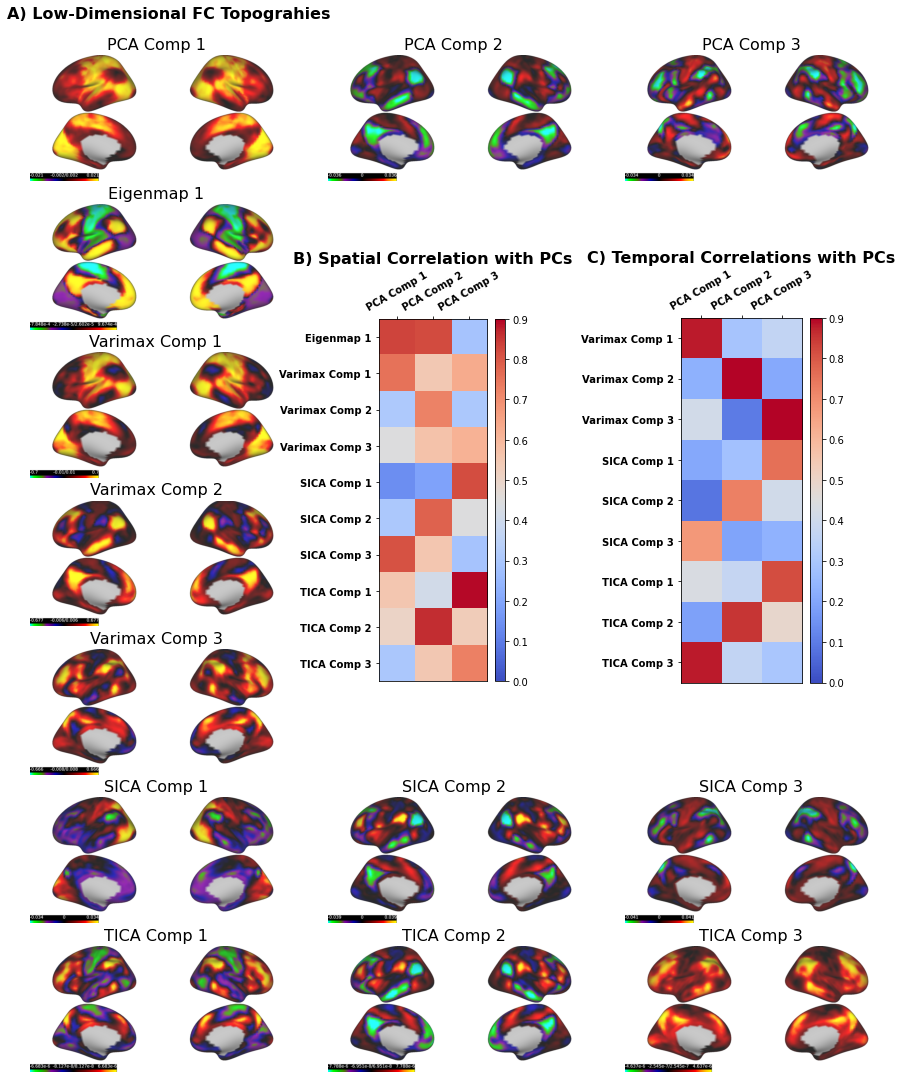

In [187]:
cifti_fps = (
    'demo_files/pca_rest.dtseries.nii',
    'demo_files/eigenmap_p90.dtseries.nii',
    'demo_files/pca_rest_varimax.dtseries.nii',
    'demo_files/s_ica.dtseries.nii', 'demo_files/t_ica.dtseries.nii' 
)

fps = (
    'demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png', 
    'demo_files/eigenmap_p90_comp0.png',
    'demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 
    'demo_files/pca_rest_varimax_comp2.png', 'demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 
    'demo_files/spatial_ica_comp2.png', 'demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 
    'demo_files/temporal_ica_comp2.png'
)

labels_short = (
    'PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3',
    'Eigenmap 1', 'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 
    'SICA Comp 1', 'SICA Comp 2', 'SICA Comp 3', 'TICA Comp 1', 'TICA Comp 2', 
    'TICA Comp 3'
 )

pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))[:,:3]
varimax_ts = pickle.load(open('demo_files/varimax_ts.pkl', 'rb'))
tica_ts = pickle.load(open('demo_files/tica_ts.pkl', 'rb'))
sica_ts = pickle.load(open('demo_files/sica_ts.pkl', 'rb'))
all_ts = [pca_ts, varimax_ts, sica_ts, tica_ts]
corr_time = np.corrcoef(np.hstack(all_ts).T)


## 1. Load All Maps
cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    if any([label in fp for label in ['pca_rest', 'ica']]):
        cifti_maps_all.append(cifti_maps[:3, :])
    elif 'eigenmap' in fp:
        cifti_maps_all.append(cifti_maps[0, :])
    else:
        cifti_maps_all.append(cifti_maps[:2, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()
# # Normalize
corr_maps = np.corrcoef(cifti_maps_all)
# cifti_maps_all = zscore(cifti_maps_all.T)

fig = plt.figure(figsize=(16,22), constrained_layout=False)
# gspec = fig.add_gridspec(5,3, hspace=0.2, wspace=0, height_ratios=[0.85,0.01,0.15])
gspec = fig.add_gridspec(9,3, hspace=0.2, wspace=0, height_ratios=[0.01,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15])

title_ax = fig.add_subplot(gspec[0,:])
title_ax.set_title('A) Low-Dimensional FC Topograhies', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')

# title_ax = fig.add_subplot(gspec[1,:])
# title_ax.set_title('B) Spatial and Temporal Correlations with Principal Components', 
#                    fontsize=16, fontweight='bold', loc='left')
# title_ax.axis('off')

# g_sub0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gspec[0], hspace=0, height_ratios=[0.73,0.27])
# g_sub0_0 = gridspec.GridSpecFromSubplotSpec(2,4, subplot_spec=g_sub0[0], hspace=0, wspace=0)
# g_sub0_1 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub0[1], wspace=0)
crop_width = (35, 150)
crop_height = (5,15)

# indx=3
# for i in range(3):
#     for j in range(4):
#         if indx < 11:
#             ax = fig.add_subplot(g_sub0_0[i,j])
#         elif indx < 14:
#             ax = fig.add_subplot(g_sub0_1[j])
#         else:
#             break
#         img = mpimg.imread(fps[indx])
#         ax.set_title(labels_short[indx], fontsize=16)
#         ax.imshow(cropImage(img,crop_width,crop_height))
#         ax.axis('off')
#         indx+=1
        
indx=0
grid_indices = ([1,0], [1,1], [1,2], [2,0], [3,0], [4,0], [5,0], [6,0], 
                [6,1], [6,2], [7,0], [7,1], [7,2])
for g_indx in grid_indices:
    ax = fig.add_subplot(gspec[g_indx[0], g_indx[1]])
    img = mpimg.imread(fps[indx])
    ax.set_title(labels_short[indx], fontsize=16)
    ax.imshow(cropImage(img,crop_width,crop_height))
    ax.axis('off')
    indx+=1

# g_sub1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[2])
ax = fig.add_subplot(gspec[3:6,1])
im = ax.imshow(np.abs(corr_maps[:3,3:].T), aspect=0.3, cmap='coolwarm', vmin=0, vmax=0.9)
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(len(labels_short[3:])))
ax.set_yticklabels(labels_short[3:], fontweight='bold')
ax.set_xticklabels(labels_short[:3], rotation=30, fontweight='bold')
ax.xaxis.tick_top()
ax.set_title('B) Spatial Correlation with PCs', fontsize=16, fontweight='bold', loc='center')
ax.set_aspect(1)
box = ax.get_position()
box.x0 = box.x0 - 0.01
box.x1 = box.x1 - 0.01
box.y0 = box.y0 + 0.04
box.y1 = box.y1 + 0.04
ax.set_position(box)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
cbar = plt.colorbar(im, orientation='vertical', cax=cax)


ax = fig.add_subplot(gspec[3:6,2])
im = ax.imshow(np.abs(corr_time[:3,3:].T), aspect=0.25, cmap='coolwarm', vmin=0, vmax=0.9)
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(len(labels_short[4:])))
ax.set_yticklabels(labels_short[4:], fontweight='bold')
ax.set_xticklabels(labels_short[:3], rotation=30, fontweight='bold')
ax.xaxis.tick_top()
ax.set_title('C) Temporal Correlations with PCs', fontsize=16, fontweight='bold', loc='center')
ax.set_aspect(1)
box = ax.get_position()
box.y0 = box.y0 + 0.04
box.y1 = box.y1 + 0.04
ax.set_position(box)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
cbar = plt.colorbar(im, orientation='vertical', cax=cax)

plt.savefig('results/figures/supplement_latentFC.png')
plt.show()


### Supplementary Figure A Caption

(SICA=Spatial ICA; TICA = Temporal ICA). The spatial weights of components from PCA (N=3), Laplacian Eigenmaps (N=1), varimax rotation of principal components (N=3), spatial ICA (N=3) and temporal ICA (N=3). The temporal and spatial correlations (absolute value) between the components of dimension-reduction analyses and the first three principal components are shown in the middle of the plot. Note, due to the nature of the Laplacian Eigenmap algorithm as a non-linear manifold learning algorithm, time courses cannot be extracted for their components. As illustrated in the spatial and temporal correlations table, the dimension-reduction analyses are largely consistent in their spatial topographies and temporal dynamics with the first three principal components.


# <b>Supplementary Figure B - Seed-Based Topographies </b>

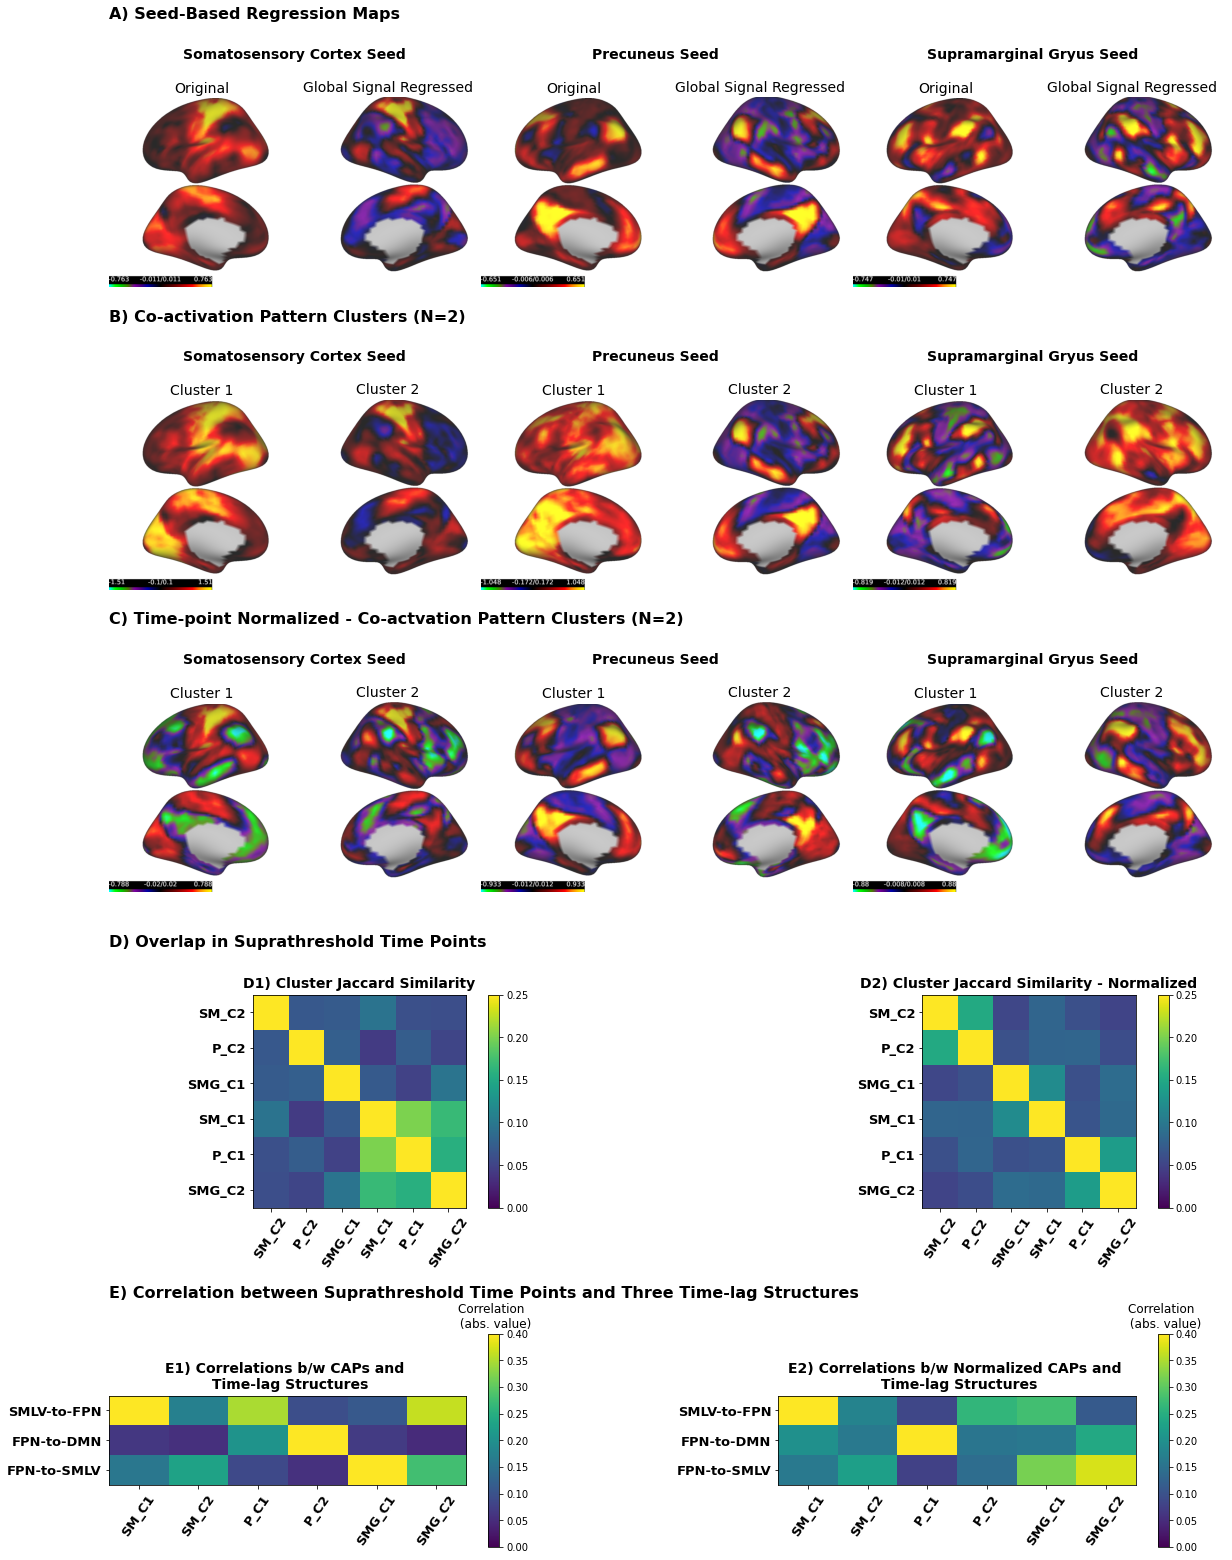

In [337]:
fps = (
    ['demo_files/fc_map_sm.png', 'demo_files/fc_map_sm_gs.png'],
    ['demo_files/fc_map_precuneus.png', 'demo_files/fc_map_precuneus_gs.png'],
    ['demo_files/fc_map_supramarginal.png', 'demo_files/fc_map_supramarginal_gs.png'], 
    ['demo_files/caps_sm_cluster0_c2.png', 'demo_files/caps_sm_cluster1_c2.png'],
    ['demo_files/caps_precuneus_cluster0_c2.png', 'demo_files/caps_precuneus_cluster1_c2.png'],
    ['demo_files/caps_supramarginal_cluster0_c2.png', 'demo_files/caps_supramarginal_cluster1_c2.png'],
    ['demo_files/caps_sm_norm_cluster0_c2.png', 'demo_files/caps_sm_norm_cluster1_c2.png'],
    ['demo_files/caps_precuneus_norm_cluster0_c2.png', 'demo_files/caps_precuneus_norm_cluster1_c2.png'],
    ['demo_files/caps_supramarginal_norm_cluster0_c2.png', 'demo_files/caps_supramarginal_norm_cluster1_c2.png']
)

pca_complex_res = pickle.load(open('results/pca_rest_complex_results.pkl', 'rb'))['pca']
comp_ts_real = np.real(pca_complex_res['pc_scores'][:,:3])

crop_width_L = (35, 1200)
crop_width_R = (1100, 150)
crop_height = (5,20)
fig = plt.figure(figsize=(20,28), constrained_layout=False)
gspec = fig.add_gridspec(2,1, hspace=0.05, wspace=0, 
                         height_ratios=[0.6,0.4])

g_sub0 = gridspec.GridSpecFromSubplotSpec(9,6, hspace=0.2, wspace=0, subplot_spec=gspec[0], 
                                          height_ratios=[0.001,0.02,0.3,
                                                         0.001,0.02,0.3,
                                                         0.001,0.02,0.3])
g_sub1 = gridspec.GridSpecFromSubplotSpec(4,6, hspace=0.3, wspace=0, subplot_spec=gspec[1], 
                                          height_ratios=[0.01,0.4,
                                                         0.1,0.4])

title_ax = fig.add_subplot(g_sub0[0,:])
title_ax.set_title('A) Seed-Based Regression Maps', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')
title_ax = fig.add_subplot(g_sub0[3,:])
title_ax.set_title('B) Co-activation Pattern Clusters (N=2)', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')
title_ax = fig.add_subplot(g_sub0[6,:])
title_ax.set_title('C) Time-point Normalized - Co-actvation Pattern Clusters (N=2)', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')
title_ax = fig.add_subplot(g_sub1[0,:])
title_ax.set_title('D) Overlap in Suprathreshold Time Points', 
                   fontsize=16, fontweight='bold', loc='left')
title_ax.axis('off')
title_ax = fig.add_subplot(g_sub1[2,:])
title_ax.text(0, 0,'E) Correlation between Suprathreshold Time Points and Three Time-lag Structures', 
                   fontsize=16, fontweight='bold')
title_ax.axis('off')

axis_rows = [1,4,7]
for row in axis_rows:
    sub_title = fig.add_subplot(g_sub0[row,:2])
    sub_title.text(0.2, 0, 'Somatosensory Cortex Seed', 
                   fontsize=14, fontweight='bold')
    sub_title.axis('off')
    sub_title = fig.add_subplot(g_sub0[row,2:4])
    sub_title.text(0.3, 0, 'Precuneus Seed', 
                   fontsize=14, fontweight='bold')
    sub_title.axis('off')
    sub_title = fig.add_subplot(g_sub0[row,4:6])
    sub_title.text(0.2, 0, 'Supramarginal Gryus Seed', 
                   fontsize=14, fontweight='bold')
    sub_title.axis('off')

indx = 0
for fp_list in fps[:3]:
    for fp in fp_list:
        if indx % 2 == 0:
            crop_w = crop_width_L
            label='Original'
        else:
            crop_w = crop_width_R
            label='Global Signal Regressed'
        ax = fig.add_subplot(g_sub0[2,indx])
        img = mpimg.imread(fp)
        ax.set_title(label, fontsize=14)
        ax.imshow(cropImage(img,crop_w,crop_height))
        ax.axis('off')
        indx+=1

indx = 0
for fp_list in fps[3:6]:
    for fp in fp_list:
        if indx % 2 == 0:
            crop_w = crop_width_L
            label='Cluster 1'
        else:
            crop_w = crop_width_R
            label='Cluster 2'
        ax = fig.add_subplot(g_sub0[5,indx])
        img = mpimg.imread(fp)
        ax.set_title(label, fontsize=14)
        ax.imshow(cropImage(img,crop_w,crop_height))
        ax.axis('off')
        indx+=1

indx = 0
for fp_list in fps[6:]:
    for fp in fp_list:
        if indx % 2 == 0:
            crop_w = crop_width_L
            label='Cluster 1'
        else:
            crop_w = crop_width_R
            label='Cluster 2'
        ax = fig.add_subplot(g_sub0[8,indx])
        img = mpimg.imread(fp)
        ax.set_title(label, fontsize=14)
        ax.imshow(cropImage(img,crop_w,crop_height))
        ax.axis('off')
        indx+=1

# Load and create CAP time series
seeds = ['sm', 'precuneus', 'supramarginal']
seed_labels = ['SM', 'P', 'SMG']
clus_ts = {}
clus_ts_norm = {}
for seed, seed_label in zip(seeds, seed_labels):
    clus_ts[seed_label] = {}
    clus_ts_norm[seed_label] = {}
    caps_res = pickle.load(open(f'results/caps_{seed}_c2_results.pkl', 'rb'))
    caps_res_norm = pickle.load(open(f'results/caps_{seed}_norm_c2_results.pkl', 'rb'))
    ts_indx = caps_res[2] 
    clus_indx = caps_res[1]
    ts_indx_norm = caps_res_norm[2]
    clus_indx_norm = caps_res_norm[1]
    for clus in [0,1]:
        clus_ts_indx = ts_indx[clus_indx==clus]
        clus_ts_indx_norm = ts_indx_norm[clus_indx_norm==clus]
        ts_tmp = np.zeros(n_ts)
        ts_tmp_norm = np.zeros(n_ts)
        ts_tmp[clus_ts_indx] = 1
        ts_tmp_norm[clus_ts_indx_norm] = 1
        clus_ts[seed_label][f'C{clus+1}'] = ts_tmp
        clus_ts_norm[seed_label][f'C{clus+1}'] = ts_tmp_norm

# Create dataframe of CAP time series      
all_ts = []
all_ts_norm = []
all_ts_labels = []
for seed in seed_labels:
    for clus in ['C1', 'C2']:
        all_ts.append(clus_ts[seed][clus])
        all_ts_norm.append(clus_ts_norm[seed][clus])
        all_ts_labels.append(seed + '_' + clus)
all_ts = pd.DataFrame(np.array(all_ts).T, columns=all_ts_labels)
all_ts_norm = pd.DataFrame(np.array(all_ts_norm).T, columns=all_ts_labels)

# Calculate overlap in CAP time series w/ jaccard similarity
sim_mat = np.zeros((6,6))
sim_mat_norm = np.zeros((6,6))
sim_mat_lag = np.zeros((6,6))
sim_mat_lag_norm = np.zeros((6,6))
for x in range(6):
    for y in range(x,6):
        x_ts = all_ts.iloc[:, [x]]; x_ts_norm = all_ts_norm.iloc[:, [x]]
        y_ts = all_ts.iloc[:, [y]]; y_ts_norm = all_ts_norm.iloc[:, [y]]
        lags = list(range(-30,31))
        lag_jaccard = [1 - cdist(x_ts.shift(i).values.T, y_ts.values.T, 'jaccard')[0] 
                       for i in lags]
        lag_jaccard_norm = [1 - cdist(x_ts_norm.shift(i).values.T, y_ts_norm.values.T, 'jaccard')[0] 
                            for i in lags]
        max_jaccard = np.max(lag_jaccard); max_jaccard_norm = np.max(lag_jaccard_norm)
        max_jaccard_lag = lags[np.argmax(lag_jaccard)]
        max_jaccard_lag_norm = lags[np.argmax(lag_jaccard_norm)]
        sim_mat[x,y] = max_jaccard; sim_mat_norm[x,y] = max_jaccard_norm
        sim_mat_lag[x,y] = max_jaccard_lag; sim_mat_lag_norm[x,y] = max_jaccard_lag_norm
i_lower = np.tril_indices(6, -1)
sim_mat[i_lower] = sim_mat.T[i_lower]
sim_mat_norm[i_lower] = sim_mat_norm.T[i_lower]
sim_mat_lag[i_lower] = sim_mat_lag.T[i_lower]
sim_mat_lag_norm[i_lower] = sim_mat_lag_norm.T[i_lower]

# Sort jaccard similarity matrix
labels = [1, 0, 1, 0, 0, 1]
sort_indx = np.argsort(labels)
sorted_vals = np.sort(labels)
labels_sorted = [all_ts_labels[i] for i in sort_indx]
sortedmat = [[sim_mat[i,j] for j in sort_indx] for i in sort_indx]
sim_mat_sorted = pd.DataFrame(sortedmat, columns = labels_sorted, index=labels_sorted)
sortedmat = [[sim_mat_norm[i,j] for j in sort_indx] for i in sort_indx]
sim_mat_sorted_norm = pd.DataFrame(sortedmat, columns = labels_sorted, index=labels_sorted)

g_sub1_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub1[1, :], wspace=0.5)
ax1 = fig.add_subplot(g_sub1_0[0])
ax2 = fig.add_subplot(g_sub1_0[1])

im1 = ax1.imshow(sim_mat_sorted, vmin=0, vmax=0.25)
ax1.set_xticks(np.arange(6))
ax1.set_yticks(np.arange(6))
ax1.set_yticklabels(labels_sorted, fontsize=13, fontweight='bold')
ax1.set_xticklabels(labels_sorted, fontsize=13, rotation=55, fontweight='bold')
ax1.set_title('D1) Cluster Jaccard Similarity', fontsize=14, 
              fontweight='bold', loc='center', pad=7)
plt.colorbar(im1, ax=ax1)


im2 = ax2.imshow(sim_mat_sorted_norm, vmin=0, vmax=0.25)
ax2.set_xticks(np.arange(6))
ax2.set_yticks(np.arange(6))
ax2.set_yticklabels(labels_sorted, fontsize=13, fontweight='bold')
ax2.set_xticklabels(labels_sorted, fontsize=13, rotation=55, fontweight='bold')
ax2.set_title('D2) Cluster Jaccard Similarity - Normalized', fontsize=14, 
              fontweight='bold', loc='center', pad=7)
plt.colorbar(im2, ax=ax2)



g_sub1_1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=g_sub1[3, :], wspace=0.5)
ax1 = fig.add_subplot(g_sub1_1[0])
ax2 = fig.add_subplot(g_sub1_1[1])

# Calculate correlation between CAP time series and time-lag structures
corr_mat = np.zeros((3,6))
corr_mat_norm = np.zeros((3,6))
corr_mat_lag = np.zeros((3,6))
corr_mat_lag_norm = np.zeros((3,6))
for x in range(3):
    for y in range(6):
        pc_ts = pd.Series(comp_ts[:, x])
        cap_ts = all_ts.iloc[:, y]; cap_ts_norm = all_ts_norm.iloc[:, y]
        lags = list(range(-30,31))
        lag_corr = np.abs([pc_ts.corr(cap_ts.shift(i)) for i in lags])
        lag_corr_norm = np.abs([pc_ts.corr(cap_ts_norm.shift(i)) for i in lags])
        max_corr = np.max(lag_corr); max_corr_norm = np.max(lag_corr_norm)
        max_corr_lag = lags[np.argmax(lag_corr)]
        max_corr_lag_norm = lags[np.argmax(lag_corr_norm)]
        corr_mat[x,y] = max_corr; corr_mat_norm[x,y] = max_corr_norm
        corr_mat_lag[x,y] = max_corr_lag; corr_mat_lag_norm[x,y] = max_corr_lag_norm

pc_labels = ['SMLV-to-FPN', 'FPN-to-DMN', 'FPN-to-SMLV']

im1 = ax1.imshow(corr_mat, vmin=0, vmax=0.4)
cax = plt.colorbar(im1, ax=ax1)
cax.ax.set_title('Correlation \n (abs. value)')
ax1.set_xticks(np.arange(6))
ax1.set_yticks(np.arange(3))
ax1.set_yticklabels(pc_labels, fontsize=13, fontweight='bold')
ax1.set_xticklabels(all_ts_labels, fontsize=13, rotation=55, fontweight='bold')
ax1.set_title('E1) Correlations b/w CAPs and \n Time-lag Structures', fontsize=14, 
              fontweight='bold', loc='center', pad=7)
ax1.set_aspect(0.5)

im2 = ax2.imshow(corr_mat_norm, vmin=0, vmax=0.4)
cax = plt.colorbar(im2, ax=ax2)
cax.ax.set_title('Correlation \n (abs. value)')
ax2.set_xticks(np.arange(6))
ax2.set_yticks(np.arange(3))
ax2.set_yticklabels(pc_labels, fontsize=13, fontweight='bold')
ax2.set_xticklabels(all_ts_labels, fontsize=13, rotation=55, fontweight='bold')
ax2.set_title('E2) Correlations b/w Normalized CAPs and \n Time-lag Structures', fontsize=14, 
              fontweight='bold', loc='center', pad=7)
ax2.set_aspect(0.5)


plt.savefig('results/figures/supplement_seeds.png')
plt.show()

### Supplementary Figure B Caption

(SM = somatosensory cortex; P=Precuneus; SMG=Supramarginal Gyrus). Spatial topographies of seed-based regression maps and CAP centroids from somatosensory (SM), precuneus and supramarginal gyrus seeds. A) Seed-based regression maps with (left hemisphere) and without global signal regression (right hemisphere) for SM, precuneus and supramarginal gyrus seeds. B) CAP cluster centroids (N=2) from k-means clustering of non-normalized (i.e. not z-scored) suprathreshold time points from SM, precuneus and supramarginal seeds. C) CAP cluster centroids (N=2) of the same suprathreshold time points with normalization (i.e. z-scored) before input to the k-means clustering algorithm. D1) Temporal overlap between binary time courses (see main text) of the two CAPs from each seed using the Jaccard similarity (Jaccard index). The Jaccard similarity between two CAP binary time courses varies from 0 to 1, and reflects the ratio of overlapping onset time points (=1) to the total number of time points (N=60,000).  D2) Temporal overlap between CAP binary time courses from the normalized solutions of each seed analysis. E) Temporal correlation between the beginning phase time course of the three time-lag structures (SMLV-to-FPN, FPN-to-DMN and FPN-to-SMLV) and the CAP binary time courses for the non-normalized (E1) and normalized (E) solutions.

# <b> Supplementary Figure C1. Global BOLD Propagation Simulation.</b>

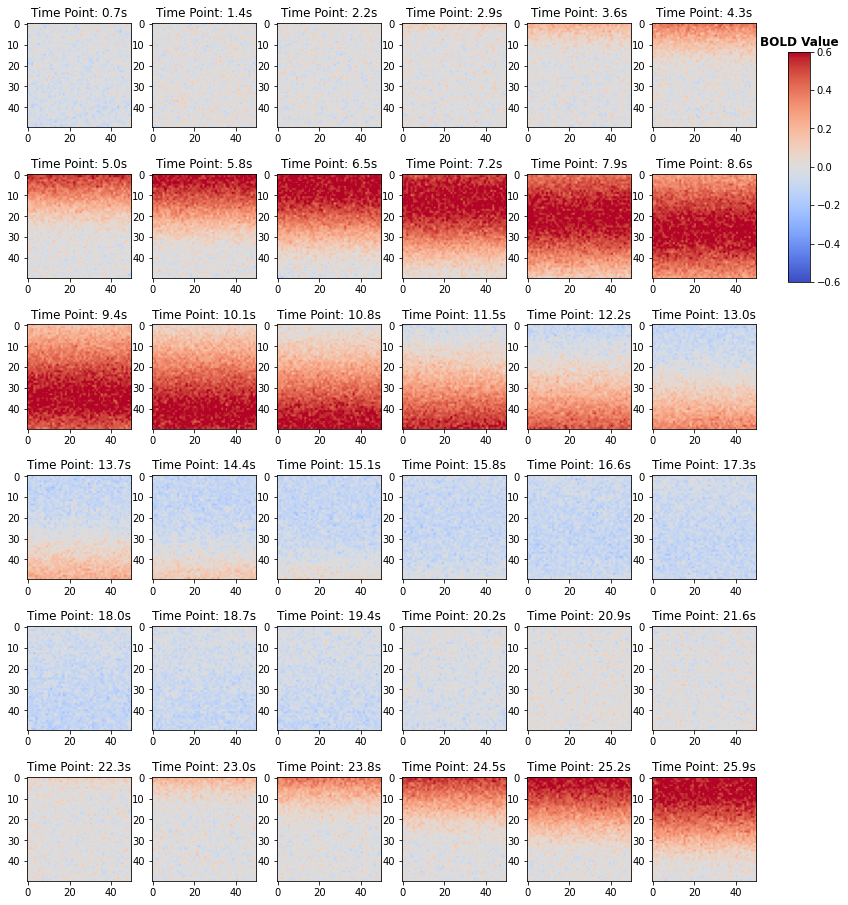

In [524]:
std_noise = 0.05; # noise-to-signal ratio
n_per_shift = 50
ts_len = 2000  
phase_jitter=10
amplitude_jitter=0.5
phase_shift = 10
start = 50
ts_sampling=0.01
n_repeats=500
n_resample = np.int(ts_len*ts_sampling/tr)*n_repeats

travel_region = range(50)

all_ts = np.zeros((50,50,n_resample))

indx = 0


for i, n in enumerate(travel_region):
    all_ts[indx,:,:] = create_hrf_group(n_per_shift, start, ts_len, tr, 1, phase_jitter, amplitude_jitter, ts_sampling, n_repeats)
    all_ts[indx,:,:] += np.array([std_noise*rand.randn(all_ts.shape[2]) for n in range(n_per_shift)])
    start += phase_shift
    indx += 1


all_ts_2d = [(all_ts[i,j,:], (i,j)) for i in range(all_ts.shape[0]) for j in range(all_ts.shape[1])]
mat_2d = np.array([ts[0] for ts in all_ts_2d]).T

fig, ax = plt.subplots(6,6,figsize=(15,16))

for i, ax in enumerate(fig.axes):
    im = ax.imshow(all_ts[:,:,i], cmap='coolwarm', vmin=-0.6, vmax=0.6)
    ax.set_title(f'Time Point: {round((i+1)*tr,1)}s')

fig.subplots_adjust(right=0.8, hspace=0.3)
cbar_ax = fig.add_axes([0.83, 0.65, 0.02, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("BOLD Value", fontsize=12, fontweight='bold')
plt.savefig('results/figures/supplementaryC_simulation.png')
plt.show()


### Supplementary Figure C1 Caption

The first ~25 sec of an artificially constructed BOLD propagation simulation. Artificial ‘vertices’ are arranged along a 50-by-50 spatial grid. Vertex time series are created by convolving simple impulse time series with the canonical hemodynamic response function. The time-series of each vertex in the grid are time-lagged such that vertex time series in the upper part of the grid peak first, while those in the bottom part peak last. As observed from the first ~25 sec snapshots of the spatial grid, a positive BOLD propagation sweeps from the top of the grid towards the bottom in the first 10 seconds. Due to the undershoot following the peak in the canonical hemodynamic response function, this positive propagation event is followed by a mirrored slightly negative propagation event.


# <b> Supplementary Figure C2. Complex Principal Component Analysis Simulation</b>

<ipython-input-2-198a7b00c62a>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


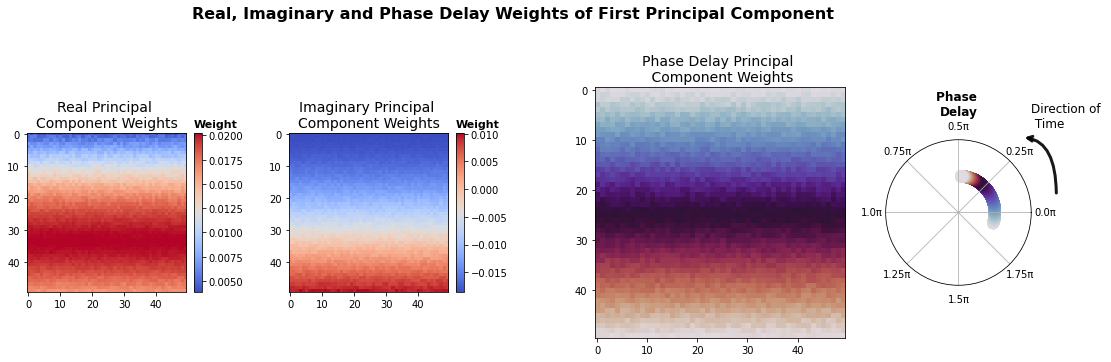

In [527]:
# Compute cPCA on simulation
mat_2d_c = hilbert(zscore(mat_2d), axis=0)
pca_res = cpca(mat_2d_c.conj(), 1)
real_weights = np.real(pca_res['Va'])*-1 # sign flip for ease of interpretation
imag_weights = np.imag(pca_res['Va'])*-1 # sign flip for ease of interpretation
phase_weights = np.angle(pca_res['Va']*-1) # rotate by 90 degrees for viz purposes

fig = plt.figure(figsize=(18,6))
fig.suptitle('Real, Imaginary and Phase Delay Weights of First Principal Component', fontsize=16, fontweight='bold')

gspec = fig.add_gridspec(1,2, wspace=0.3, width_ratios=[0.5, 0.5])
g_sub0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[0], wspace=0.5)
g_sub1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[1], wspace=0.1, width_ratios=[0.65,0.35])
ax0 = fig.add_subplot(g_sub0[0])
ax1 = fig.add_subplot(g_sub0[1])
ax2 = fig.add_subplot(g_sub1[0])
ax3 = fig.add_subplot(g_sub1[1], projection='polar')

im0 = ax0.imshow(real_weights.reshape(50,50), cmap='coolwarm')
im1 = ax1.imshow(imag_weights.reshape(50,50), cmap='coolwarm')
im2 = ax2.imshow(phase_weights.reshape(50,50), cmap='twilight')

ax0.set_title(f'Real Principal \nComponent Weights', fontsize=14)
ax1.set_title(f'Imaginary Principal \nComponent Weights', fontsize=14)
ax2.set_title(f'Phase Delay Principal \n Component Weights', fontsize=14)

divider0 = make_axes_locatable(ax0)
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cax2.axis('off')
cbar0 = plt.colorbar(im0, cax=cax0)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar0.ax.set_title("Weight", fontsize=11, loc='left', fontweight='bold')
cbar1.ax.set_title("Weight", fontsize=11, loc='left', fontweight='bold')

twilight_cmap = plt.get_cmap('twilight')
xval = np.arange(-0.3, 1.5, 0.001)
yval = np.ones_like(xval)
twilight_shifted = shiftedColorMap(twilight_cmap, midpoint=0.75)
norm = colors.Normalize(-0.3, 1.5)
ax3.scatter(xval, yval, c=xval, s=150, cmap=twilight_shifted, norm=norm, linewidths=0)
ax3.set_yticks([])
convert_polar_xticks_to_radians(ax3)
ax3.set_title("Phase \nDelay", fontsize=12, loc='center', fontweight='bold')
ax3.margins(x=0, y=-0.25) 
# plt.annotate('Direction of \nTime ', xy=(0.96, 0.5), xytext=(0.96,0.3),
#              xycoords='figure fraction',
#              textcoords='figure fraction', 
#              arrowprops=dict(facecolor='black', shrink=0.05),
#              ha='center'
#             )
ax3.annotate("",
            xy=(0.95,0.46),  
            xytext=(0.915, 0.62),    
            xycoords='figure fraction',
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', arrowstyle='<-', connectionstyle="angle3, angleA=0, angleB=90", alpha = 0.9, linewidth=3),
            fontsize=12,
            horizontalalignment='right',
            verticalalignment='top',
            bbox=dict(pad=5, facecolor="none", edgecolor="none")
)
ax3.text(0.9, 0.7, 'Direction of \n Time', transform=plt.gcf().transFigure, fontsize=12)

plt.savefig('results/figures/supplementaryC2_simulationPCA.png', bbox_inches='tight')
# plt.show()

### Supplementary Figure C2

The real part, imaginary part and phase delay weights of the first complex principal component (cPC) spatial weights derived from the propagation simulation. The real and imaginary parts (left) of the cPC correspond to snapshots of the grid values at phases t=0 and t=0+2. A sketch of the temporal dynamics of the propagating simulation can be derived from comparing the activity patterns of the real and imaginary parts of the cPC. Comparing the activity patterns between the two phases indicates the cPC captures the progression of activity down the grid over time. The phase delay representation of the cPC (right) represents the phase-delay between different points of the grid of the cPC. The phase delay representation is colored according to the phase delay of each point in the grid, and the progression of time can be read by moving ‘up’ the colormap, or in terms of a color wheel - moving counterclockwise.  This provides a more complete description of the time-lag structure of the propagation simulation. 


# <b>Supplementary Figure D. Principal Component and Functional Connectivity Gradient Topographies</b>

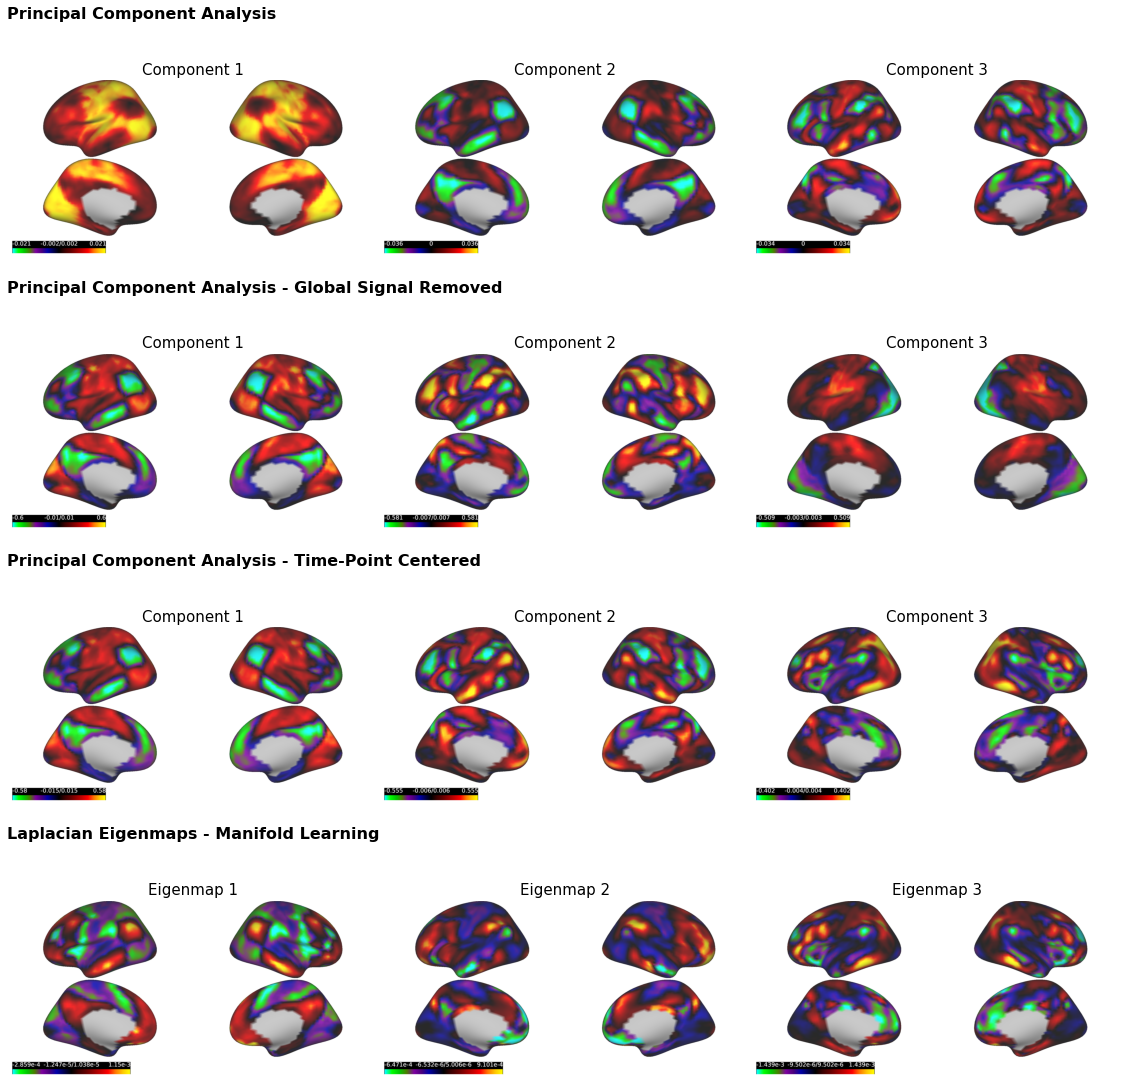

In [529]:
fps = [['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'],
       ['demo_files/pca_rest_gs_comp0.png', 'demo_files/pca_rest_gs_comp1.png', 'demo_files/pca_rest_gs_comp2.png'],
       ['demo_files/pca_rest_comp0_tmode.png', 'demo_files/pca_rest_comp1_tmode.png', 'demo_files/pca_rest_comp2_tmode.png'],
       ['demo_files/eigenmap_p0_comp0.png', 'demo_files/eigenmap_p0_comp1.png', 'demo_files/diffusion_emb_comp2.png']]
labels = [['Component 1', 'Component 2', 'Component 3'],
          ['Component 1', 'Component 2', 'Component 3'],
          ['Component 1', 'Component 2', 'Component 3'],
          ['Eigenmap 1', 'Eigenmap 2', 'Eigenmap 3']]
section_labels = ['Principal Component Analysis', 
                  'Principal Component Analysis - Global Signal Removed',
                  'Principal Component Analysis - Time-Point Centered',
                  'Laplacian Eigenmaps - Manifold Learning']

fig = plt.figure(figsize=(20,20), constrained_layout=False)
gspec = fig.add_gridspec(8,3, hspace=0.05, wspace=0, 
                         height_ratios=[0.01,0.2,0.01,0.2,0.01,0.2,0.01,0.2])

title_inds = [0,2,4,6]
for title_indx, label in zip(title_inds, section_labels):
    title_ax = fig.add_subplot(gspec[title_indx,:])
    title_ax.set_title(label,fontsize=16, fontweight='bold', loc='left')
    title_ax.axis('off')
    
img_inds = [1,3,5,7]
for fp_sec, label_sec, img_indx in zip(fps, labels, img_inds):
    for i in range(3):
        ax = fig.add_subplot(gspec[img_indx,i])
        img = mpimg.imread(fp_sec[i])
        ax.set_title(label_sec[i], fontsize=15)
        ax.imshow(img)
        ax.axis('off')

fig.set_facecolor('w')
plt.savefig('results/figures/supplementaryD_pcagradients.png')
plt.show()

### Supplementary Figure D Caption

Displayed are the FC topography spatial weights from PCA, PCA on global-signal regressed data, PCA on time-point centered data, and Laplacian Eigenmaps. Note, we observed that the eigenmaps were highly positively skewed. To make the negative values of the eigenmaps more visible the colormap is made non-symmetric. The first and second eigenmaps match the second and third principal component from PCA. The first principal component is missing from the LE, global-signal regressed, and time-point centered PCA solutions.


# <b>Supplementary Figure E. Comparison of Lag Projections With and Without Global Signal Regression.</b>

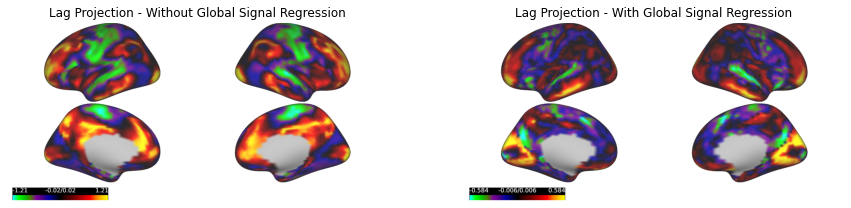

In [42]:
fps = ['demo_files/lag_projection.png', 'demo_files/lag_projection_gs.png']
labels = ['Lag Projection - Without Global Signal Regression', 
          'Lag Projection - With Global Signal Regression']

fig, axs = plt.subplots(figsize=(15, 15) , nrows=1, ncols=2) 
img = mpimg.imread(fps[0])
axs[0].imshow(img)
axs[0].set_title(labels[0])
axs[0].axis('off')

img = mpimg.imread(fps[1])
axs[1].imshow(img)
axs[1].set_title(labels[1])
axs[1].axis('off')


fig.set_facecolor('w')
plt.show()
# plt.savefig('results/figures/supplementaryG_lag_projection.png')

### Figure E Caption

Lag projections with and without global signal regression as a preprocessing step. Values on each cortical map represent the average time-delay between each cortical vertex and all others. Time-delay values are colored from light green/blue (earlier in time) to bright yellow/green (later in time). The range between the earliest and latest time-delay values are significantly shorter for lag projections on global-signal regressed data.


## Appendix I - Code to Calculate Average Duration of Complex Principal Components

<font size='4'>The following code was used to calculate the duration of the first three complex principal components. The procedure was as follows: 1) the temporal phase was derived from the complex principal component time series, 2) the phase was unwrapped, and 3) the average duration was calculated as the average time from start (0) to end (2pi) for all cycles of the component time series. </font>

In [469]:
# pca_complex_res = pickle.load(open('results/pca_rest_complex_results.pkl', 'rb'))

# comp0_phase = np.unwrap(np.angle(pca_complex_res['pc_scores'][:,0]))
# comp1_phase = np.unwrap(np.angle(pca_complex_res['pc_scores'][:,1]))
# comp2_phase = np.unwrap(np.angle(pca_complex_res['pc_scores'][:,2]))

# avg_cycle_comp0 = (comp0_phase[-1]-comp0_phase[0])/60000
# avg_cycle_comp0 = (2*np.pi)/avg_cycle_comp0

# avg_cycle_comp1 = (comp1_phase[-1]-comp1_phase[0])/60000
# avg_cycle_comp1 = (2*np.pi)/avg_cycle_comp1

# avg_cycle_comp2 = (comp2_phase[-1]-comp2_phase[0])/60000
# avg_cycle_comp2 = (2*np.pi)/avg_cycle_comp2

## Scratch Code

In [201]:
pca_complex_res = pickle.load(open('results/pca_rest_complex_results.pkl', 'rb'))
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
sica_ts = pickle.load(open('demo_files/sica_ts.pkl', 'rb'))
pca_ts_c = pickle.load(open('demo_files/pca_gs_ts.pkl', 'rb'))
varimax_ts = pickle.load(open('demo_files/varimax_ts.pkl', 'rb'))
gs_signal = pickle.load(open('demo_files/gs_results.pkl', 'rb'))
qpp_ts = pickle.load(open('results/qpp_results.pkl', 'rb'))[3]

pca_complex_ts = pca_complex_res['pca']['pc_scores']

xcorr(zscore(np.imag(pca_complex_ts[:,0])), zscore(np.real(pca_complex_ts[:,2]).T), maxlags=30) # 

In [ ]:
_, cifti_maps_real, n_time = pull_cifti_data(load_cifti('results/pca_rest_complex_real.dtseries.nii'))
_, cifti_maps_imag, n_time = pull_cifti_data(load_cifti('results/pca_rest_complex_imag.dtseries.nii'))
_, cifti_eigenmap_p90, n_time = pull_cifti_data(load_cifti('results/eigenmap_thres/eigenmap_p90.dtseries.nii'))

_, cifti_maps_pseed, n_time = pull_cifti_data(load_cifti('results/fc_map_precuneus.dtseries.nii'))
_, cifti_maps_pseed_gs, n_time = pull_cifti_data(load_cifti('results/fc_map_gs_precuneus.dtseries.nii'))
_, cifti_maps_smseed, n_time = pull_cifti_data(load_cifti('results/fc_map_sm.dtseries.nii'))
_, cifti_maps_smseed_gs, n_time = pull_cifti_data(load_cifti('results/fc_map_gs_sm.dtseries.nii'))
_, cifti_maps_spseed, n_time = pull_cifti_data(load_cifti('results/fc_map_supramarginal.dtseries.nii'))
_, cifti_maps_spseed_gs, n_time = pull_cifti_data(load_cifti('results/fc_map_gs_supramarginal.dtseries.nii'))


zero_mask = np.std(cifti_maps_real, axis=0) > 0

cifti_maps_real = cifti_maps_real[:, zero_mask].copy()
cifti_maps_imag = cifti_maps_imag[:, zero_mask].copy()
cifti_eigenmap_p90 = cifti_eigenmap_p90[0, zero_mask].copy()

cifti_maps_pseed = cifti_maps_pseed[:, zero_mask].copy()
cifti_maps_pseed_gs = cifti_maps_pseed_gs[:, zero_mask].copy()
cifti_maps_smseed = cifti_maps_smseed[:, zero_mask].copy()
cifti_maps_smseed_gs = cifti_maps_smseed_gs[:, zero_mask].copy()
cifti_maps_spseed = cifti_maps_spseed[:, zero_mask].copy()
cifti_maps_spseed_gs = cifti_maps_spseed_gs[:, zero_mask].copy()
